In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import *
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### settings

In [2]:
save_dir = "./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/"

In [3]:
N_SPLITS = 5
MAX_THREADS = 8
N_TRAIN = 10
max_num = 127
min_num = -128

### process

In [5]:
from scipy.signal import butter, sosfilt
import pywt

n_samples = 800000
sample_duration = 0.02
sample_rate = n_samples * (1 / sample_duration)

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = sosfilt(sos, x)
    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per" )
    for level in range(1, len(coeff)):
        uthresh = (1/0.6745) * maddest(coeff[-level]) * np.sqrt( 2*np.log(len(coeff[-level])))
        coeff[-level] = pywt.threshold(coeff[-level], value=uthresh, mode='hard')
    return pywt.waverec(coeff, wavelet, mode='per')

In [6]:
df_train = pd.read_csv('../data/input/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])

In [7]:
def get_features(dataset='train', split_parts=10):
    if dataset == 'train':
        cache_file = 'X.npy'
        meta_file = '../data/input/metadata_train.csv'
    elif dataset == 'test':
        cache_file = 'X_test.npy'
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, MAX_THREADS), verbose=1)(delayed(prep_data)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    if dataset == 'train':
        # y = meta_df.loc[meta_df['phase']==0, 'target'].values
        # y = meta_df.groupby("id_measurement")["target"].max().sort_index().values
        y = meta_df.groupby("id_measurement")["target"].sum().values
        y[y < 2] = 0
        y[y >= 2] = 1

        np.save(save_dir + "X.npy", X)
        np.save(save_dir + "y.npy", y)
    elif dataset == 'test':
        y = None
        np.save(save_dir + "X_test.npy", X)

    return X, y

In [8]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [9]:
from scipy.signal import butter, sosfilt, find_peaks, peak_prominences
import pywt
distance = 50
prominence = 1 / max_num
    
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    #ts = high_pass_filter(ts, low_cutoff=10000)
    ts = denoise_signal(ts, wavelet='db4', level=1)
    ts = min_max_transf(ts, min_data=min_num, max_data=max_num)
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    
    for i in range(0, sample_size, bucket_size):
        ts_range = ts[i:i + bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry

        new_ts.append(np.concatenate([
            np.asarray([mean, std, std_top, std_bot, max_range]),
            percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [10]:
def prep_data(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")
    X = []
    for sids in signal_ids:
        data = praq_data[[str(s) for s in sids]].values.T
        X_signal = [transform_ts(signal, n_dim=160) for signal in data]
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    return X

In [11]:
X, y = get_features("train", split_parts=8)
print(X.shape, y.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.4min remaining: 10.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.5min finished


(2904, 160, 57) (2904,)


In [4]:
X = np.load(save_dir + "X.npy")
y = np.load(save_dir + "y.npy")
print(X.shape, y.shape)

(2904, 160, 57) (2904,)


In [13]:
%%time
meta_test = pd.read_csv('../data/input/metadata_test.csv')
meta_test = meta_test.set_index(['signal_id'])
X_test_input, _ = get_features("test", split_parts=8)
X_test_input.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  7.2min remaining: 21.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  7.3min finished


CPU times: user 1.52 s, sys: 2.48 s, total: 4 s
Wall time: 7min 20s


In [5]:
X_test_input = np.load(save_dir + "X_test.npy")
print(X_test_input.shape)

(6779, 160, 57)


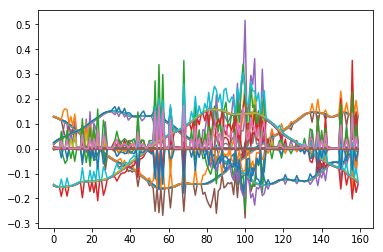

In [15]:
plt.plot(X[0, :, :])
plt.show()

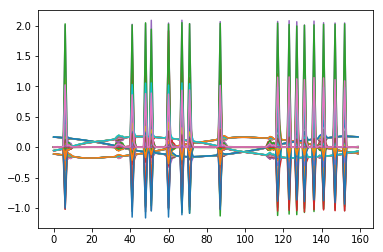

In [16]:
plt.plot(X[6878//3, :, :])
plt.show()

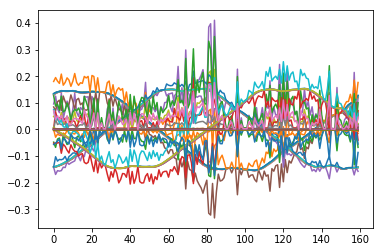

In [17]:
plt.plot(X_test_input[0, :, :])
plt.show()

### set model

In [18]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [19]:
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    
    return model

In [20]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### train adversal validation

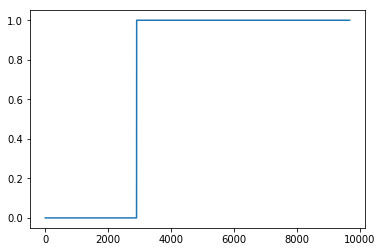

((9683, 160, 57), (9683,), 6779.0)

In [21]:
X_total = np.concatenate((X, X_test_input))
y_total = np.ones(len(X_total))
y_total[:len(X)] = 0

plt.plot(y_total)
plt.show()
X_total.shape, y_total.shape, y_total.sum()

In [22]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)), str(round(roc_val,4))), end=100*' '+'\n')
        logs['val_auc'] = roc_val
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [23]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_total, y_total))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X_total[train_idx], y_total[train_idx], X_total[val_idx], y_total[val_idx]
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    ckpt = ModelCheckpoint(
        save_dir + 'weights_{}.h5'.format(idx), save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_auc', mode='max'
    )
    roc_auc = roc_callback(training_data=(train_X, train_y), validation_data=(val_X, val_y))
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode="max")

    model.fit(
        train_X, train_y, batch_size=128, epochs=100,
        validation_data=[val_X, val_y], callbacks=[roc_auc, ckpt, early_stopping]
    )
    
    model.load_weights(save_dir + 'weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 7746 samples, validate on 1937 samples
Epoch 1/100
7746/7746 [==============================] - 6s 797us/step - loss: 0.6157 - val_loss: 0.5999
roc-auc: 0.5854 - roc-auc_val: 0.605                                                                                                    

Epoch 00001: val_auc improved from -inf to 0.60502, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0.h5
Epoch 2/100
7746/7746 [==============================] - 3s 412us/step - loss: 0.6025 - val_loss: 0.5895
roc-auc: 0.6115 - roc-auc_val: 0.6398                                                                                                    

Epoch 00002: val_auc improved from 0.60502 to 0.63979, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0.h5
Epoch 3/100
7746/7746 [==============================] - 3s 426us/step - loss: 0.5901 - val_loss: 0.5784
roc-auc: 0.6641 - roc-auc_val: 0.699                                  

7746/7746 [==============================] - 3s 415us/step - loss: 0.2471 - val_loss: 0.2348
roc-auc: 0.9643 - roc-auc_val: 0.9558                                                                                                    

Epoch 00024: val_auc did not improve from 0.96241
Epoch 25/100
7746/7746 [==============================] - 3s 412us/step - loss: 0.2360 - val_loss: 0.4196
roc-auc: 0.908 - roc-auc_val: 0.9013                                                                                                    

Epoch 00025: val_auc did not improve from 0.96241
Epoch 26/100
7746/7746 [==============================] - 3s 419us/step - loss: 0.2268 - val_loss: 0.2592
roc-auc: 0.9611 - roc-auc_val: 0.9518                                                                                                    

Epoch 00026: val_auc did not improve from 0.96241
Epoch 27/100
7746/7746 [==============================] - 3s 421us/step - loss: 0.2166 - val_loss: 0.2400
roc-auc: 0.9663 - roc-a

7746/7746 [==============================] - 3s 418us/step - loss: 0.4786 - val_loss: 0.4379
roc-auc: 0.8486 - roc-auc_val: 0.8485                                                                                                    

Epoch 00008: val_auc improved from 0.77220 to 0.84854, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_2.h5
Epoch 9/100
7746/7746 [==============================] - 3s 423us/step - loss: 0.4229 - val_loss: 0.4374
roc-auc: 0.8434 - roc-auc_val: 0.8329                                                                                                    

Epoch 00009: val_auc did not improve from 0.84854
Epoch 10/100
7746/7746 [==============================] - 3s 412us/step - loss: 0.4211 - val_loss: 0.4705
roc-auc: 0.8154 - roc-auc_val: 0.8026                                                                                                    

Epoch 00010: val_auc did not improve from 0.84854
Epoch 11/100
7746/7746 [=================

7746/7746 [==============================] - 3s 419us/step - loss: 0.1836 - val_loss: 0.2215
roc-auc: 0.9778 - roc-auc_val: 0.9683                                                                                                    

Epoch 00033: val_auc improved from 0.96812 to 0.96833, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_2.h5
Epoch 34/100
7746/7746 [==============================] - 3s 419us/step - loss: 0.1873 - val_loss: 0.2054
roc-auc: 0.9764 - roc-auc_val: 0.9677                                                                                                    

Epoch 00034: val_auc did not improve from 0.96833
Epoch 35/100
7746/7746 [==============================] - 3s 418us/step - loss: 0.1848 - val_loss: 0.2124
roc-auc: 0.9764 - roc-auc_val: 0.9642                                                                                                    

Epoch 00035: val_auc did not improve from 0.96833
Epoch 36/100
7746/7746 [================

7746/7746 [==============================] - 3s 399us/step - loss: 0.4526 - val_loss: 0.4057
roc-auc: 0.8907 - roc-auc_val: 0.8791                                                                                                    

Epoch 00010: val_auc improved from 0.83025 to 0.87908, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3.h5
Epoch 11/100
7746/7746 [==============================] - 3s 413us/step - loss: 0.3559 - val_loss: 0.3874
roc-auc: 0.897 - roc-auc_val: 0.886                                                                                                    

Epoch 00011: val_auc improved from 0.87908 to 0.88595, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3.h5
Epoch 12/100
7746/7746 [==============================] - 3s 407us/step - loss: 0.3260 - val_loss: 0.4297
roc-auc: 0.8835 - roc-auc_val: 0.8612                                                                                                    

Epoc

7748/7748 [==============================] - 3s 396us/step - loss: 0.2050 - val_loss: 0.2665
roc-auc: 0.9674 - roc-auc_val: 0.9491                                                                                                    

Epoch 00031: val_auc did not improve from 0.95584
Epoch 32/100
7748/7748 [==============================] - 3s 390us/step - loss: 0.2162 - val_loss: 0.3248
roc-auc: 0.944 - roc-auc_val: 0.9277                                                                                                    

Epoch 00032: val_auc did not improve from 0.95584
Epoch 33/100
7748/7748 [==============================] - 3s 414us/step - loss: 0.2097 - val_loss: 0.2843
roc-auc: 0.9567 - roc-auc_val: 0.9398                                                                                                    

Epoch 00033: val_auc did not improve from 0.95584
Epoch 34/100
7748/7748 [==============================] - 3s 417us/step - loss: 0.2109 - val_loss: 0.2311
roc-auc: 0.9772 - roc-a

((9683,), (9683,))

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, preds_val)

0.9632746079795121

In [25]:
target = np.ones(len(X_total))
target = target * -1
target[:len(y)] = y
target.shape, target[target != -1].sum(), y.sum()

((9683,), 175.0, 175)

In [26]:
val_idx_list = []
for idx, (train_idx, val_idx) in enumerate(splits):
    val_idx_list.append(val_idx)
val_idx_list = np.concatenate(val_idx_list)

In [27]:
result = []
for idx, preds, test_flg in zip(val_idx_list, preds_val, y_val):
    result.append((idx, preds, test_flg))

result = pd.DataFrame(result, columns=["idx", "preds", "test_flg"])
result = result.sort_values("idx").reset_index(drop=True)
result["target"] = target
result.head()

,idx,preds,test_flg,target
0,0,0.118761,0.0,0.0
1,1,0.403666,0.0,1.0
2,2,0.005546,0.0,0.0
3,3,0.003310,0.0,0.0
4,4,0.002331,0.0,0.0


175.0


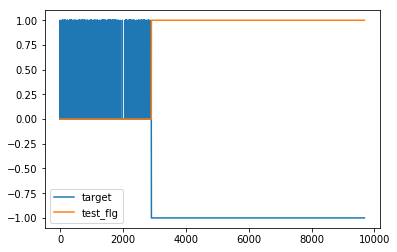

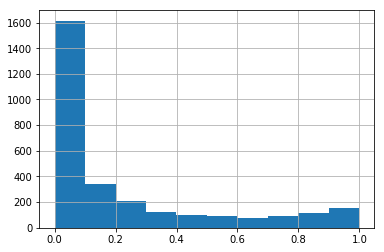

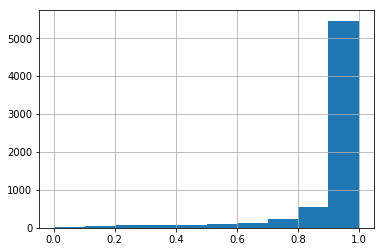

In [28]:
# check
print(result.query("test_flg == 0").target.sum())
result[["target", "test_flg"]].plot()
plt.show()
result.query("test_flg == 0").preds.hist()
plt.show()
result.query("test_flg == 1").preds.hist()
plt.show()

In [29]:
result.to_csv(save_dir + "adversarial_validation_result.csv", index=False, header=True)

### get adversal validation result

In [8]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0")
print(ad_train.test_flg.sum(), ad_train.target.sum(), y.sum())
ad_train.head()

0.0 175.0 175


,idx,preds,test_flg,target
0,0,0.118761,0.0,0.0
1,1,0.403666,0.0,1.0
2,2,0.005546,0.0,0.0
3,3,0.003310,0.0,0.0
4,4,0.002331,0.0,0.0


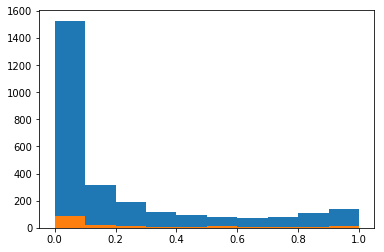

In [9]:
plt.hist(ad_train.query("target == 0")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.hist(ad_train.query("target == 1")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.show()

In [10]:
# cut adversarial probabilities (for train) in 5 buckets
adver_idx_08_to_1 = ad_train.query("preds >= 0.80").idx.tolist()
adver_idx_06_to_08 = ad_train.query("0.80 > preds >= 0.60").idx.tolist()
adver_idx_04_to_06 = ad_train.query("0.60 > preds >= 0.40").idx.tolist()
adver_idx_02_to_04 = ad_train.query("0.40 > preds >= 0.20").idx.tolist()
adver_idx_00_to_02 = ad_train.query("0.20 > preds >= 0.00").idx.tolist()

print(len(adver_idx_08_to_1), len(adver_idx_06_to_08), len(adver_idx_04_to_06), len(adver_idx_02_to_04), len(adver_idx_00_to_02))
print(len(adver_idx_08_to_1)+len(adver_idx_06_to_08)+len(adver_idx_04_to_06)+len(adver_idx_02_to_04)+len(adver_idx_00_to_02))
print(len(y))

print(y[adver_idx_08_to_1].sum(), y[adver_idx_06_to_08].sum(), y[adver_idx_04_to_06].sum(), y[adver_idx_02_to_04].sum(), y[adver_idx_00_to_02].sum())
print(y[adver_idx_08_to_1].sum()+y[adver_idx_06_to_08].sum()+y[adver_idx_04_to_06].sum()+y[adver_idx_02_to_04].sum()+y[adver_idx_00_to_02].sum())
print(y.sum())

263 168 192 327 1954
2904
2904
20 12 16 17 110
175
175


In [11]:
adver_idx_08_to_1_pos = ad_train.query("preds >= 0.80 & target == 1").idx.tolist()
adver_idx_06_to_08_pos = ad_train.query("0.80 > preds >= 0.60 & target == 1").idx.tolist()
adver_idx_04_to_06_pos = ad_train.query("0.60 > preds >= 0.40 & target == 1").idx.tolist()
adver_idx_02_to_04_pos = ad_train.query("0.40 > preds >= 0.20 & target == 1").idx.tolist()
adver_idx_00_to_02_pos = ad_train.query("0.20 > preds >= 0.00 & target == 1").idx.tolist()

print(len(adver_idx_08_to_1_pos), len(adver_idx_06_to_08_pos), len(adver_idx_04_to_06_pos), len(adver_idx_02_to_04_pos), len(adver_idx_00_to_02_pos))
print(len(adver_idx_08_to_1_pos)+len(adver_idx_06_to_08_pos)+len(adver_idx_04_to_06_pos)+len(adver_idx_02_to_04_pos)+len(adver_idx_00_to_02_pos))
print(len(y))

20 12 16 17 110
175
2904


In [12]:
fold_index = np.zeros(len(y))
fold_index[adver_idx_08_to_1] = 1
fold_index[adver_idx_08_to_1_pos] = 2
fold_index[adver_idx_06_to_08] = 3
fold_index[adver_idx_06_to_08_pos] = 4
fold_index[adver_idx_04_to_06] = 5
fold_index[adver_idx_04_to_06_pos] = 6
fold_index[adver_idx_02_to_04] = 7
fold_index[adver_idx_02_to_04_pos] = 8
fold_index[adver_idx_00_to_02] = 9
fold_index[adver_idx_00_to_02_pos] = 10

print(len(fold_index[fold_index==1]), len(fold_index[fold_index==2]), len(fold_index[fold_index==1])+len(fold_index[fold_index==2]))
print(len(fold_index[fold_index==3]), len(fold_index[fold_index==4]), len(fold_index[fold_index==3])+len(fold_index[fold_index==4]))
print(len(fold_index[fold_index==5]), len(fold_index[fold_index==6]), len(fold_index[fold_index==5])+len(fold_index[fold_index==6]))
print(len(fold_index[fold_index==7]), len(fold_index[fold_index==8]), len(fold_index[fold_index==7])+len(fold_index[fold_index==8]))
print(len(fold_index[fold_index==9]), len(fold_index[fold_index==10]), len(fold_index[fold_index==9])+len(fold_index[fold_index==10]))

243 20 263
156 12 168
176 16 192
310 17 327
1844 110 1954


### train

In [6]:
best_thr_list = []
best_score_list = []
preds_val_list = []

def threshold_search(y_true, y_proba):
    thresholds = np.linspace(0.0, 1.0, 101)
    scores = [matthews_corrcoef(y_true, (y_proba > t).astype(np.uint8)) for t in thresholds]
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

In [36]:
def train_per_fold(n_train, idx, train_X, train_y, val_X, val_y):
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[matthews_correlation])
    save_model_name = f'weights_{n_train}_{idx}.h5'
    ckpt = ModelCheckpoint(
        save_dir + save_model_name, save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max'
    )    
    model.fit(
        train_X, train_y, batch_size=128, epochs=50, verbose=1,
        validation_data=[val_X, val_y], callbacks=[ckpt]
    )

    model.load_weights(save_dir + save_model_name)
    preds_train = np.squeeze(model.predict(train_X, batch_size=512))
    preds_val = np.squeeze(model.predict(val_X, batch_size=512))
    preds_test = np.squeeze(model.predict(X_test_input, batch_size=300, verbose=1))
    
    return preds_train, preds_val, preds_test

In [37]:
splits = list(StratifiedKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        K.clear_session()
        print("Beginning fold {}".format(idx+1))
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]        
        preds_train, preds_val, preds_test = train_per_fold(n_train, idx, train_X, train_y, val_X, val_y)
        np.save(save_dir + f"preds_train_{n_train}_{idx}.npy", preds_train)
        np.save(save_dir + f"preds_val_{n_train}_{idx}.npy", preds_val)
        np.save(save_dir + f"preds_test_{n_train}_{idx}.npy", preds_test)

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))

===== n_train = 0 =====
Beginning fold 1
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 2s 921us/step - loss: 0.3566 - matthews_correlation: 0.0068 - val_loss: 0.2379 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_0.h5
Epoch 2/50
2319/2319 [==============================] - 1s 442us/step - loss: 0.2146 - matthews_correlation: 0.0000e+00 - val_loss: 0.1978 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2319/2319 [==============================] - 1s 437us/step - loss: 0.1729 - matthews_correlation: -7.5877e-04 - val_loss: 0.1676 - val_matthews_correlation: 0.2191

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.21913, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_0.h5
Epoc

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.41000000000000003, 0.7603035082142877)
val result: (0.4, 0.751709811252909)
Beginning fold 2
Train on 2322 samples, validate on 582 samples
Epoch 1/50
2322/2322 [==============================] - 2s 968us/step - loss: 0.3336 - matthews_correlation: 0.0000e+00 - val_loss: 0.2208 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_1.h5
Epoch 2/50
2322/2322 [==============================] - 1s 437us/step - loss: 0.2085 - matthews_correlation: 0.0840 - val_loss: 0.2246 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2322/2322 [==============================] - 1s 432us/step - loss: 0.2119 - matthews_correlation: 0.0000e+00 - val_loss: 0.2044 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2322/2322 [


Epoch 00031: val_matthews_correlation did not improve from 0.70606
Epoch 32/50
2322/2322 [==============================] - 1s 422us/step - loss: 0.0775 - matthews_correlation: 0.7094 - val_loss: 0.1125 - val_matthews_correlation: 0.6206

Epoch 00032: val_matthews_correlation did not improve from 0.70606
Epoch 33/50
2322/2322 [==============================] - 1s 434us/step - loss: 0.0769 - matthews_correlation: 0.7318 - val_loss: 0.1016 - val_matthews_correlation: 0.6738

Epoch 00033: val_matthews_correlation did not improve from 0.70606
Epoch 34/50
2322/2322 [==============================] - 1s 440us/step - loss: 0.0784 - matthews_correlation: 0.7048 - val_loss: 0.1100 - val_matthews_correlation: 0.5902

Epoch 00034: val_matthews_correlation did not improve from 0.70606
Epoch 35/50
2322/2322 [==============================] - 1s 441us/step - loss: 0.0814 - matthews_correlation: 0.6842 - val_loss: 0.1142 - val_matthews_correlation: 0.6192

Epoch 00035: val_matthews_correlation did n

Epoch 13/50
2324/2324 [==============================] - 1s 418us/step - loss: 0.0990 - matthews_correlation: 0.6798 - val_loss: 0.1188 - val_matthews_correlation: 0.6240

Epoch 00013: val_matthews_correlation improved from 0.61563 to 0.62396, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_2.h5
Epoch 14/50
2324/2324 [==============================] - 1s 415us/step - loss: 0.0973 - matthews_correlation: 0.6593 - val_loss: 0.1079 - val_matthews_correlation: 0.6145

Epoch 00014: val_matthews_correlation did not improve from 0.62396
Epoch 15/50
2324/2324 [==============================] - 1s 415us/step - loss: 0.0921 - matthews_correlation: 0.6951 - val_loss: 0.1135 - val_matthews_correlation: 0.6400

Epoch 00015: val_matthews_correlation improved from 0.62396 to 0.63997, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_2.h5
Epoch 16/50
2324/2324 [==============================] - 1s 435us/step - loss: 0.0918 - matthews_correl

2324/2324 [==============================] - 1s 429us/step - loss: 0.0942 - matthews_correlation: 0.6126 - val_loss: 0.1129 - val_matthews_correlation: 0.6396

Epoch 00045: val_matthews_correlation did not improve from 0.68284
Epoch 46/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.0846 - matthews_correlation: 0.6649 - val_loss: 0.1120 - val_matthews_correlation: 0.6400

Epoch 00046: val_matthews_correlation did not improve from 0.68284
Epoch 47/50
2324/2324 [==============================] - 1s 439us/step - loss: 0.0792 - matthews_correlation: 0.7252 - val_loss: 0.1055 - val_matthews_correlation: 0.5594

Epoch 00047: val_matthews_correlation did not improve from 0.68284
Epoch 48/50
2324/2324 [==============================] - 1s 429us/step - loss: 0.0821 - matthews_correlation: 0.6901 - val_loss: 0.1103 - val_matthews_correlation: 0.6098

Epoch 00048: val_matthews_correlation did not improve from 0.68284
Epoch 49/50
2324/2324 [==============================] -

2325/2325 [==============================] - 1s 424us/step - loss: 0.0889 - matthews_correlation: 0.6831 - val_loss: 0.0969 - val_matthews_correlation: 0.7078

Epoch 00025: val_matthews_correlation did not improve from 0.71632
Epoch 26/50
2325/2325 [==============================] - 1s 439us/step - loss: 0.0938 - matthews_correlation: 0.7213 - val_loss: 0.1009 - val_matthews_correlation: 0.7147

Epoch 00026: val_matthews_correlation did not improve from 0.71632
Epoch 27/50
2325/2325 [==============================] - 1s 432us/step - loss: 0.0811 - matthews_correlation: 0.7567 - val_loss: 0.0905 - val_matthews_correlation: 0.7675

Epoch 00027: val_matthews_correlation improved from 0.71632 to 0.76747, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_3.h5
Epoch 28/50
2325/2325 [==============================] - 1s 428us/step - loss: 0.0842 - matthews_correlation: 0.7067 - val_loss: 0.0849 - val_matthews_correlation: 0.7290

Epoch 00028: val_matthews_correla


Epoch 00006: val_matthews_correlation improved from 0.45815 to 0.60661, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_4.h5
Epoch 7/50
2326/2326 [==============================] - 1s 421us/step - loss: 0.1126 - matthews_correlation: 0.6044 - val_loss: 0.1013 - val_matthews_correlation: 0.6065

Epoch 00007: val_matthews_correlation did not improve from 0.60661
Epoch 8/50
2326/2326 [==============================] - 1s 415us/step - loss: 0.1115 - matthews_correlation: 0.6548 - val_loss: 0.0889 - val_matthews_correlation: 0.5901

Epoch 00008: val_matthews_correlation did not improve from 0.60661
Epoch 9/50
2326/2326 [==============================] - 1s 416us/step - loss: 0.0989 - matthews_correlation: 0.6406 - val_loss: 0.0902 - val_matthews_correlation: 0.6225

Epoch 00009: val_matthews_correlation improved from 0.60661 to 0.62255, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_0_4.h5
Epoch 10/50
2326/2326 [===============


Epoch 00039: val_matthews_correlation did not improve from 0.77135
Epoch 40/50
2326/2326 [==============================] - 1s 424us/step - loss: 0.0802 - matthews_correlation: 0.7031 - val_loss: 0.0861 - val_matthews_correlation: 0.7269

Epoch 00040: val_matthews_correlation did not improve from 0.77135
Epoch 41/50
2326/2326 [==============================] - 1s 409us/step - loss: 0.0851 - matthews_correlation: 0.7003 - val_loss: 0.0791 - val_matthews_correlation: 0.7465

Epoch 00041: val_matthews_correlation did not improve from 0.77135
Epoch 42/50
2326/2326 [==============================] - 1s 413us/step - loss: 0.0743 - matthews_correlation: 0.7512 - val_loss: 0.0845 - val_matthews_correlation: 0.6956

Epoch 00042: val_matthews_correlation did not improve from 0.77135
Epoch 43/50
2326/2326 [==============================] - 1s 415us/step - loss: 0.0751 - matthews_correlation: 0.7486 - val_loss: 0.0735 - val_matthews_correlation: 0.8129

Epoch 00043: val_matthews_correlation impro


Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_1_1.h5
Epoch 2/50
2322/2322 [==============================] - 1s 435us/step - loss: 0.2088 - matthews_correlation: 0.1061 - val_loss: 0.2023 - val_matthews_correlation: 0.2934

Epoch 00002: val_matthews_correlation improved from 0.00000 to 0.29339, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_1_1.h5
Epoch 3/50
2322/2322 [==============================] - 1s 439us/step - loss: 0.1813 - matthews_correlation: 0.3958 - val_loss: 0.1779 - val_matthews_correlation: 0.3911

Epoch 00003: val_matthews_correlation improved from 0.29339 to 0.39109, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_1_1.h5
Epoch 4/50
2322/2322 [==============================] - 1s 441us/step - loss: 0.1585 - matthews_correlation: 0.4250 - val_loss: 0.1478 - val_matthews_correlation: 0.0756

Epoch 00004: val_m


Epoch 00013: val_matthews_correlation did not improve from 0.67459
Epoch 14/50
2324/2324 [==============================] - 1s 434us/step - loss: 0.0958 - matthews_correlation: 0.6795 - val_loss: 0.1093 - val_matthews_correlation: 0.6977

Epoch 00014: val_matthews_correlation improved from 0.67459 to 0.69771, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_1_2.h5
Epoch 15/50
2324/2324 [==============================] - 1s 442us/step - loss: 0.0893 - matthews_correlation: 0.6908 - val_loss: 0.1019 - val_matthews_correlation: 0.6292

Epoch 00015: val_matthews_correlation did not improve from 0.69771
Epoch 16/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0859 - matthews_correlation: 0.6973 - val_loss: 0.1013 - val_matthews_correlation: 0.6182

Epoch 00016: val_matthews_correlation did not improve from 0.69771
Epoch 17/50
2324/2324 [==============================] - 1s 423us/step - loss: 0.0880 - matthews_correlation: 0.6837 - val_lo


Epoch 00028: val_matthews_correlation did not improve from 0.67419
Epoch 29/50
2325/2325 [==============================] - 1s 416us/step - loss: 0.0811 - matthews_correlation: 0.6986 - val_loss: 0.1085 - val_matthews_correlation: 0.5829

Epoch 00029: val_matthews_correlation did not improve from 0.67419
Epoch 30/50
2325/2325 [==============================] - 1s 422us/step - loss: 0.0821 - matthews_correlation: 0.7030 - val_loss: 0.1081 - val_matthews_correlation: 0.6059

Epoch 00030: val_matthews_correlation did not improve from 0.67419
Epoch 31/50
2325/2325 [==============================] - 1s 422us/step - loss: 0.0803 - matthews_correlation: 0.6557 - val_loss: 0.1084 - val_matthews_correlation: 0.5759

Epoch 00031: val_matthews_correlation did not improve from 0.67419
Epoch 32/50
2325/2325 [==============================] - 1s 430us/step - loss: 0.0801 - matthews_correlation: 0.7001 - val_loss: 0.1169 - val_matthews_correlation: 0.6509

Epoch 00032: val_matthews_correlation did n


Epoch 00009: val_matthews_correlation improved from 0.61967 to 0.72002, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_1_4.h5
Epoch 10/50
2326/2326 [==============================] - 1s 415us/step - loss: 0.1001 - matthews_correlation: 0.6673 - val_loss: 0.1000 - val_matthews_correlation: 0.4828

Epoch 00010: val_matthews_correlation did not improve from 0.72002
Epoch 11/50
2326/2326 [==============================] - 1s 414us/step - loss: 0.1010 - matthews_correlation: 0.5998 - val_loss: 0.1027 - val_matthews_correlation: 0.5445

Epoch 00011: val_matthews_correlation did not improve from 0.72002
Epoch 12/50
2326/2326 [==============================] - 1s 429us/step - loss: 0.0962 - matthews_correlation: 0.6794 - val_loss: 0.0857 - val_matthews_correlation: 0.6240

Epoch 00012: val_matthews_correlation did not improve from 0.72002
Epoch 13/50
2326/2326 [==============================] - 1s 430us/step - loss: 0.0983 - matthews_correlation: 0.6511 - val_lo

2326/2326 [==============================] - 1s 430us/step - loss: 0.0877 - matthews_correlation: 0.6959 - val_loss: 0.0918 - val_matthews_correlation: 0.7274

Epoch 00043: val_matthews_correlation did not improve from 0.76363
Epoch 44/50
2326/2326 [==============================] - 1s 417us/step - loss: 0.0975 - matthews_correlation: 0.6866 - val_loss: 0.1143 - val_matthews_correlation: 0.5555

Epoch 00044: val_matthews_correlation did not improve from 0.76363
Epoch 45/50
2326/2326 [==============================] - 1s 422us/step - loss: 0.0956 - matthews_correlation: 0.6502 - val_loss: 0.0915 - val_matthews_correlation: 0.6970

Epoch 00045: val_matthews_correlation did not improve from 0.76363
Epoch 46/50
2326/2326 [==============================] - 1s 414us/step - loss: 0.0842 - matthews_correlation: 0.6911 - val_loss: 0.0837 - val_matthews_correlation: 0.7222

Epoch 00046: val_matthews_correlation did not improve from 0.76363
Epoch 47/50
2326/2326 [==============================] -

2322/2322 [==============================] - 1s 425us/step - loss: 0.1509 - matthews_correlation: 0.4257 - val_loss: 0.1387 - val_matthews_correlation: 0.3856

Epoch 00004: val_matthews_correlation improved from 0.25964 to 0.38563, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_2_1.h5
Epoch 5/50
2322/2322 [==============================] - 1s 436us/step - loss: 0.1383 - matthews_correlation: 0.5142 - val_loss: 0.1345 - val_matthews_correlation: 0.3498

Epoch 00005: val_matthews_correlation did not improve from 0.38563
Epoch 6/50
2322/2322 [==============================] - 1s 438us/step - loss: 0.1241 - matthews_correlation: 0.5452 - val_loss: 0.1142 - val_matthews_correlation: 0.5587

Epoch 00006: val_matthews_correlation improved from 0.38563 to 0.55866, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_2_1.h5
Epoch 7/50
2322/2322 [==============================] - 1s 433us/step - loss: 0.1126 - matthews_correlation: 0.5370 -

2324/2324 [==============================] - 1s 426us/step - loss: 0.0924 - matthews_correlation: 0.6398 - val_loss: 0.1073 - val_matthews_correlation: 0.6535

Epoch 00016: val_matthews_correlation did not improve from 0.69765
Epoch 17/50
2324/2324 [==============================] - 1s 435us/step - loss: 0.0888 - matthews_correlation: 0.6867 - val_loss: 0.1178 - val_matthews_correlation: 0.4675

Epoch 00017: val_matthews_correlation did not improve from 0.69765
Epoch 18/50
2324/2324 [==============================] - 1s 441us/step - loss: 0.0928 - matthews_correlation: 0.6630 - val_loss: 0.1123 - val_matthews_correlation: 0.6891

Epoch 00018: val_matthews_correlation did not improve from 0.69765
Epoch 19/50
2324/2324 [==============================] - 1s 431us/step - loss: 0.0901 - matthews_correlation: 0.6453 - val_loss: 0.1154 - val_matthews_correlation: 0.6791

Epoch 00019: val_matthews_correlation did not improve from 0.69765
Epoch 20/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 430us/step - loss: 0.0750 - matthews_correlation: 0.7480 - val_loss: 0.1114 - val_matthews_correlation: 0.6044

Epoch 00050: val_matthews_correlation did not improve from 0.73944
6779/6779 [==============================] - 1s 121us/step
train result: (0.48, 0.744571917796862)
val result: (0.49, 0.7461244938802352)
Beginning fold 4
Train on 2325 samples, validate on 579 samples
Epoch 1/50
2325/2325 [==============================] - 2s 911us/step - loss: 0.3784 - matthews_correlation: 0.0022 - val_loss: 0.2502 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_2_3.h5
Epoch 2/50
2325/2325 [==============================] - 1s 431us/step - loss: 0.2269 - matthews_correlation: 0.0000e+00 - val_loss: 0.1992 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00

2326/2326 [==============================] - 1s 445us/step - loss: 0.1127 - matthews_correlation: 0.6538 - val_loss: 0.0853 - val_matthews_correlation: 0.6723

Epoch 00012: val_matthews_correlation did not improve from 0.76043
Epoch 13/50
2326/2326 [==============================] - 1s 443us/step - loss: 0.0999 - matthews_correlation: 0.6103 - val_loss: 0.0950 - val_matthews_correlation: 0.5896

Epoch 00013: val_matthews_correlation did not improve from 0.76043
Epoch 14/50
2326/2326 [==============================] - 1s 451us/step - loss: 0.1022 - matthews_correlation: 0.6787 - val_loss: 0.0866 - val_matthews_correlation: 0.7101

Epoch 00014: val_matthews_correlation did not improve from 0.76043
Epoch 15/50
2326/2326 [==============================] - 1s 435us/step - loss: 0.0976 - matthews_correlation: 0.7150 - val_loss: 0.0978 - val_matthews_correlation: 0.6323

Epoch 00015: val_matthews_correlation did not improve from 0.76043
Epoch 16/50
2326/2326 [==============================] -

2319/2319 [==============================] - 1s 425us/step - loss: 0.0899 - matthews_correlation: 0.6962 - val_loss: 0.1084 - val_matthews_correlation: 0.7164

Epoch 00026: val_matthews_correlation did not improve from 0.72333
Epoch 27/50
2319/2319 [==============================] - 1s 426us/step - loss: 0.0853 - matthews_correlation: 0.7193 - val_loss: 0.1033 - val_matthews_correlation: 0.7092

Epoch 00027: val_matthews_correlation did not improve from 0.72333
Epoch 28/50
2319/2319 [==============================] - 1s 422us/step - loss: 0.0814 - matthews_correlation: 0.7302 - val_loss: 0.1513 - val_matthews_correlation: 0.5932

Epoch 00028: val_matthews_correlation did not improve from 0.72333
Epoch 29/50
2319/2319 [==============================] - 1s 425us/step - loss: 0.1182 - matthews_correlation: 0.5526 - val_loss: 0.1229 - val_matthews_correlation: 0.5828

Epoch 00029: val_matthews_correlation did not improve from 0.72333
Epoch 30/50
2319/2319 [==============================] -

2322/2322 [==============================] - 1s 437us/step - loss: 0.1591 - matthews_correlation: 0.4336 - val_loss: 0.1718 - val_matthews_correlation: 0.2809

Epoch 00007: val_matthews_correlation did not improve from 0.33095
Epoch 8/50
2322/2322 [==============================] - 1s 446us/step - loss: 0.1349 - matthews_correlation: 0.5097 - val_loss: 0.1125 - val_matthews_correlation: 0.5423

Epoch 00008: val_matthews_correlation improved from 0.33095 to 0.54226, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3_1.h5
Epoch 9/50
2322/2322 [==============================] - 1s 440us/step - loss: 0.1107 - matthews_correlation: 0.5562 - val_loss: 0.1137 - val_matthews_correlation: 0.6828

Epoch 00009: val_matthews_correlation improved from 0.54226 to 0.68277, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3_1.h5
Epoch 10/50
2322/2322 [==============================] - 1s 438us/step - loss: 0.1057 - matthews_correlation: 0.6498 

2324/2324 [==============================] - 1s 439us/step - loss: 0.0888 - matthews_correlation: 0.6893 - val_loss: 0.0998 - val_matthews_correlation: 0.7277

Epoch 00019: val_matthews_correlation improved from 0.71404 to 0.72771, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3_2.h5
Epoch 20/50
2324/2324 [==============================] - 1s 441us/step - loss: 0.0868 - matthews_correlation: 0.6923 - val_loss: 0.1007 - val_matthews_correlation: 0.7113

Epoch 00020: val_matthews_correlation did not improve from 0.72771
Epoch 21/50
2324/2324 [==============================] - 1s 441us/step - loss: 0.0848 - matthews_correlation: 0.6663 - val_loss: 0.1062 - val_matthews_correlation: 0.5888

Epoch 00021: val_matthews_correlation did not improve from 0.72771
Epoch 22/50
2324/2324 [==============================] - 1s 439us/step - loss: 0.0818 - matthews_correlation: 0.7116 - val_loss: 0.1104 - val_matthews_correlation: 0.6472

Epoch 00022: val_matthews_correla

2325/2325 [==============================] - 1s 432us/step - loss: 0.2384 - matthews_correlation: 0.0000e+00 - val_loss: 0.2059 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2325/2325 [==============================] - 1s 429us/step - loss: 0.2115 - matthews_correlation: 0.0348 - val_loss: 0.1820 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2325/2325 [==============================] - 1s 435us/step - loss: 0.1926 - matthews_correlation: 0.0000e+00 - val_loss: 0.1620 - val_matthews_correlation: 0.2503

Epoch 00004: val_matthews_correlation improved from 0.00000 to 0.25032, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3_3.h5
Epoch 5/50
2325/2325 [==============================] - 1s 441us/step - loss: 0.1738 - matthews_correlation: 0.1037 - val_loss: 0.1672 - val_matthews_correlation: 0.3596

Epoch 00005: val_mat


Epoch 00033: val_matthews_correlation did not improve from 0.69609
Epoch 34/50
2325/2325 [==============================] - 1s 438us/step - loss: 0.0870 - matthews_correlation: 0.7115 - val_loss: 0.1129 - val_matthews_correlation: 0.5975

Epoch 00034: val_matthews_correlation did not improve from 0.69609
Epoch 35/50
2325/2325 [==============================] - 1s 439us/step - loss: 0.0835 - matthews_correlation: 0.7009 - val_loss: 0.1030 - val_matthews_correlation: 0.6129

Epoch 00035: val_matthews_correlation did not improve from 0.69609
Epoch 36/50
2325/2325 [==============================] - 1s 435us/step - loss: 0.0817 - matthews_correlation: 0.7072 - val_loss: 0.1113 - val_matthews_correlation: 0.6903

Epoch 00036: val_matthews_correlation did not improve from 0.69609
Epoch 37/50
2325/2325 [==============================] - 1s 437us/step - loss: 0.0828 - matthews_correlation: 0.7281 - val_loss: 0.1120 - val_matthews_correlation: 0.5952

Epoch 00037: val_matthews_correlation did n


Epoch 00015: val_matthews_correlation did not improve from 0.73280
Epoch 16/50
2326/2326 [==============================] - 1s 414us/step - loss: 0.1059 - matthews_correlation: 0.6290 - val_loss: 0.0801 - val_matthews_correlation: 0.6636

Epoch 00016: val_matthews_correlation did not improve from 0.73280
Epoch 17/50
2326/2326 [==============================] - 1s 420us/step - loss: 0.0964 - matthews_correlation: 0.6609 - val_loss: 0.0803 - val_matthews_correlation: 0.7556

Epoch 00017: val_matthews_correlation improved from 0.73280 to 0.75561, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_3_4.h5
Epoch 18/50
2326/2326 [==============================] - 1s 413us/step - loss: 0.0928 - matthews_correlation: 0.6823 - val_loss: 0.0906 - val_matthews_correlation: 0.5618

Epoch 00018: val_matthews_correlation did not improve from 0.75561
Epoch 19/50
2326/2326 [==============================] - 1s 419us/step - loss: 0.0954 - matthews_correlation: 0.6005 - val_lo

2326/2326 [==============================] - 1s 443us/step - loss: 0.0772 - matthews_correlation: 0.7342 - val_loss: 0.0797 - val_matthews_correlation: 0.7657

Epoch 00049: val_matthews_correlation did not improve from 0.78686
Epoch 50/50
2326/2326 [==============================] - 1s 441us/step - loss: 0.0838 - matthews_correlation: 0.6562 - val_loss: 0.0788 - val_matthews_correlation: 0.7213

Epoch 00050: val_matthews_correlation did not improve from 0.78686
6779/6779 [==============================] - 1s 132us/step
train result: (0.42, 0.7711709278121692)
val result: (0.49, 0.799732344728172)
===== n_train = 4 =====
Beginning fold 1
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 2s 933us/step - loss: 0.3865 - matthews_correlation: 0.0027 - val_loss: 0.2580 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_

2319/2319 [==============================] - 1s 425us/step - loss: 0.0850 - matthews_correlation: 0.6933 - val_loss: 0.1218 - val_matthews_correlation: 0.6629

Epoch 00029: val_matthews_correlation did not improve from 0.70437
Epoch 30/50
2319/2319 [==============================] - 1s 430us/step - loss: 0.1027 - matthews_correlation: 0.6610 - val_loss: 0.1075 - val_matthews_correlation: 0.6543

Epoch 00030: val_matthews_correlation did not improve from 0.70437
Epoch 31/50
2319/2319 [==============================] - 1s 436us/step - loss: 0.0876 - matthews_correlation: 0.7039 - val_loss: 0.1029 - val_matthews_correlation: 0.6501

Epoch 00031: val_matthews_correlation did not improve from 0.70437
Epoch 32/50
2319/2319 [==============================] - 1s 431us/step - loss: 0.0821 - matthews_correlation: 0.7185 - val_loss: 0.1238 - val_matthews_correlation: 0.4013

Epoch 00032: val_matthews_correlation did not improve from 0.70437
Epoch 33/50
2319/2319 [==============================] -


Epoch 00009: val_matthews_correlation improved from 0.60910 to 0.76469, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_4_1.h5
Epoch 10/50
2322/2322 [==============================] - 1s 440us/step - loss: 0.0975 - matthews_correlation: 0.6737 - val_loss: 0.0983 - val_matthews_correlation: 0.6456

Epoch 00010: val_matthews_correlation did not improve from 0.76469
Epoch 11/50
2322/2322 [==============================] - 1s 441us/step - loss: 0.0967 - matthews_correlation: 0.6037 - val_loss: 0.1097 - val_matthews_correlation: 0.6756

Epoch 00011: val_matthews_correlation did not improve from 0.76469
Epoch 12/50
2322/2322 [==============================] - 1s 439us/step - loss: 0.0994 - matthews_correlation: 0.6256 - val_loss: 0.1115 - val_matthews_correlation: 0.6582

Epoch 00012: val_matthews_correlation did not improve from 0.76469
Epoch 13/50
2322/2322 [==============================] - 1s 426us/step - loss: 0.0941 - matthews_correlation: 0.6969 - val_lo


Epoch 00043: val_matthews_correlation did not improve from 0.76469
Epoch 44/50
2322/2322 [==============================] - 1s 443us/step - loss: 0.0804 - matthews_correlation: 0.7207 - val_loss: 0.1024 - val_matthews_correlation: 0.6356

Epoch 00044: val_matthews_correlation did not improve from 0.76469
Epoch 45/50
2322/2322 [==============================] - 1s 445us/step - loss: 0.0814 - matthews_correlation: 0.7250 - val_loss: 0.1024 - val_matthews_correlation: 0.6110

Epoch 00045: val_matthews_correlation did not improve from 0.76469
Epoch 46/50
2322/2322 [==============================] - 1s 448us/step - loss: 0.0767 - matthews_correlation: 0.7380 - val_loss: 0.1017 - val_matthews_correlation: 0.7245

Epoch 00046: val_matthews_correlation did not improve from 0.76469
Epoch 47/50
2322/2322 [==============================] - 1s 433us/step - loss: 0.0760 - matthews_correlation: 0.7035 - val_loss: 0.1056 - val_matthews_correlation: 0.6525

Epoch 00047: val_matthews_correlation did n


Epoch 00023: val_matthews_correlation did not improve from 0.64055
Epoch 24/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.0953 - matthews_correlation: 0.6645 - val_loss: 0.1015 - val_matthews_correlation: 0.5856

Epoch 00024: val_matthews_correlation did not improve from 0.64055
Epoch 25/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.0942 - matthews_correlation: 0.6478 - val_loss: 0.1073 - val_matthews_correlation: 0.5932

Epoch 00025: val_matthews_correlation did not improve from 0.64055
Epoch 26/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0888 - matthews_correlation: 0.6640 - val_loss: 0.1057 - val_matthews_correlation: 0.6668

Epoch 00026: val_matthews_correlation improved from 0.64055 to 0.66678, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_4_2.h5
Epoch 27/50
2324/2324 [==============================] - 1s 445us/step - loss: 0.0828 - matthews_correlation: 0.6350 - val_lo


Epoch 00005: val_matthews_correlation improved from 0.00000 to 0.42320, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_4_3.h5
Epoch 6/50
2325/2325 [==============================] - 1s 431us/step - loss: 0.1366 - matthews_correlation: 0.4700 - val_loss: 0.1103 - val_matthews_correlation: 0.5506

Epoch 00006: val_matthews_correlation improved from 0.42320 to 0.55061, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_4_3.h5
Epoch 7/50
2325/2325 [==============================] - 1s 438us/step - loss: 0.1175 - matthews_correlation: 0.4065 - val_loss: 0.0986 - val_matthews_correlation: 0.6120

Epoch 00007: val_matthews_correlation improved from 0.55061 to 0.61202, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_4_3.h5
Epoch 8/50
2325/2325 [==============================] - 1s 435us/step - loss: 0.1026 - matthews_correlation: 0.6176 - val_loss: 0.1411 - val_matthews_correlation: 0.6305

Epoch 00008: va

2325/2325 [==============================] - 1s 412us/step - loss: 0.0806 - matthews_correlation: 0.6853 - val_loss: 0.1238 - val_matthews_correlation: 0.6391

Epoch 00037: val_matthews_correlation did not improve from 0.75578
Epoch 38/50
2325/2325 [==============================] - 1s 407us/step - loss: 0.0787 - matthews_correlation: 0.7239 - val_loss: 0.0989 - val_matthews_correlation: 0.7308

Epoch 00038: val_matthews_correlation did not improve from 0.75578
Epoch 39/50
2325/2325 [==============================] - 1s 414us/step - loss: 0.0715 - matthews_correlation: 0.7606 - val_loss: 0.0949 - val_matthews_correlation: 0.7378

Epoch 00039: val_matthews_correlation did not improve from 0.75578
Epoch 40/50
2325/2325 [==============================] - 1s 440us/step - loss: 0.0813 - matthews_correlation: 0.7545 - val_loss: 0.1103 - val_matthews_correlation: 0.6876

Epoch 00040: val_matthews_correlation did not improve from 0.75578
Epoch 41/50
2325/2325 [==============================] -

2319/2319 [==============================] - 2s 986us/step - loss: 0.3516 - matthews_correlation: -0.0031 - val_loss: 0.2505 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_5_0.h5
Epoch 2/50
2319/2319 [==============================] - 1s 413us/step - loss: 0.2187 - matthews_correlation: 0.0000e+00 - val_loss: 0.2011 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2319/2319 [==============================] - 1s 413us/step - loss: 0.1926 - matthews_correlation: 0.0000e+00 - val_loss: 0.1986 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2319/2319 [==============================] - 1s 417us/step - loss: 0.1730 - matthews_correlation: 0.2512 - val_loss: 0.1742 - val_matthews_correlation: 0.2380

Epoch 00004: val_m

2322/2322 [==============================] - 1s 450us/step - loss: 0.1047 - matthews_correlation: 0.5849 - val_loss: 0.1160 - val_matthews_correlation: 0.6406

Epoch 00013: val_matthews_correlation improved from 0.52257 to 0.64059, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_5_1.h5
Epoch 14/50
2322/2322 [==============================] - 1s 443us/step - loss: 0.1046 - matthews_correlation: 0.6621 - val_loss: 0.1184 - val_matthews_correlation: 0.5188

Epoch 00014: val_matthews_correlation did not improve from 0.64059
Epoch 15/50
2322/2322 [==============================] - 1s 440us/step - loss: 0.0915 - matthews_correlation: 0.6991 - val_loss: 0.1126 - val_matthews_correlation: 0.5331

Epoch 00015: val_matthews_correlation did not improve from 0.64059
Epoch 16/50
2322/2322 [==============================] - 1s 441us/step - loss: 0.0948 - matthews_correlation: 0.6833 - val_loss: 0.1046 - val_matthews_correlation: 0.6000

Epoch 00016: val_matthews_correla


Epoch 00044: val_matthews_correlation did not improve from 0.70638
Epoch 45/50
2322/2322 [==============================] - 1s 449us/step - loss: 0.0714 - matthews_correlation: 0.7606 - val_loss: 0.1150 - val_matthews_correlation: 0.6598

Epoch 00045: val_matthews_correlation did not improve from 0.70638
Epoch 46/50
2322/2322 [==============================] - 1s 433us/step - loss: 0.0673 - matthews_correlation: 0.7354 - val_loss: 0.1133 - val_matthews_correlation: 0.6609

Epoch 00046: val_matthews_correlation did not improve from 0.70638
Epoch 47/50
2322/2322 [==============================] - 1s 447us/step - loss: 0.0668 - matthews_correlation: 0.7192 - val_loss: 0.1163 - val_matthews_correlation: 0.6394

Epoch 00047: val_matthews_correlation did not improve from 0.70638
Epoch 48/50
2322/2322 [==============================] - 1s 431us/step - loss: 0.0661 - matthews_correlation: 0.7441 - val_loss: 0.1420 - val_matthews_correlation: 0.6341

Epoch 00048: val_matthews_correlation did n


Epoch 00025: val_matthews_correlation did not improve from 0.69122
Epoch 26/50
2324/2324 [==============================] - 1s 434us/step - loss: 0.0873 - matthews_correlation: 0.6587 - val_loss: 0.1154 - val_matthews_correlation: 0.5537

Epoch 00026: val_matthews_correlation did not improve from 0.69122
Epoch 27/50
2324/2324 [==============================] - 1s 449us/step - loss: 0.0859 - matthews_correlation: 0.6666 - val_loss: 0.1264 - val_matthews_correlation: 0.6290

Epoch 00027: val_matthews_correlation did not improve from 0.69122
Epoch 28/50
2324/2324 [==============================] - 1s 449us/step - loss: 0.0874 - matthews_correlation: 0.6678 - val_loss: 0.1088 - val_matthews_correlation: 0.6169

Epoch 00028: val_matthews_correlation did not improve from 0.69122
Epoch 29/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0827 - matthews_correlation: 0.6988 - val_loss: 0.1133 - val_matthews_correlation: 0.5439

Epoch 00029: val_matthews_correlation did n

2325/2325 [==============================] - 1s 439us/step - loss: 0.0985 - matthews_correlation: 0.6589 - val_loss: 0.1106 - val_matthews_correlation: 0.5658

Epoch 00008: val_matthews_correlation did not improve from 0.67989
Epoch 9/50
2325/2325 [==============================] - 1s 435us/step - loss: 0.0958 - matthews_correlation: 0.6277 - val_loss: 0.0948 - val_matthews_correlation: 0.5813

Epoch 00009: val_matthews_correlation did not improve from 0.67989
Epoch 10/50
2325/2325 [==============================] - 1s 430us/step - loss: 0.0962 - matthews_correlation: 0.6650 - val_loss: 0.1013 - val_matthews_correlation: 0.6462

Epoch 00010: val_matthews_correlation did not improve from 0.67989
Epoch 11/50
2325/2325 [==============================] - 1s 426us/step - loss: 0.0935 - matthews_correlation: 0.7032 - val_loss: 0.1076 - val_matthews_correlation: 0.5357

Epoch 00011: val_matthews_correlation did not improve from 0.67989
Epoch 12/50
2325/2325 [==============================] - 

2325/2325 [==============================] - 1s 438us/step - loss: 0.0724 - matthews_correlation: 0.7221 - val_loss: 0.1016 - val_matthews_correlation: 0.6839

Epoch 00042: val_matthews_correlation did not improve from 0.69893
Epoch 43/50
2325/2325 [==============================] - 1s 443us/step - loss: 0.0738 - matthews_correlation: 0.7596 - val_loss: 0.0996 - val_matthews_correlation: 0.6480

Epoch 00043: val_matthews_correlation did not improve from 0.69893
Epoch 44/50
2325/2325 [==============================] - 1s 444us/step - loss: 0.0715 - matthews_correlation: 0.7721 - val_loss: 0.1063 - val_matthews_correlation: 0.4855

Epoch 00044: val_matthews_correlation did not improve from 0.69893
Epoch 45/50
2325/2325 [==============================] - 1s 430us/step - loss: 0.0757 - matthews_correlation: 0.7167 - val_loss: 0.1024 - val_matthews_correlation: 0.6728

Epoch 00045: val_matthews_correlation did not improve from 0.69893
Epoch 46/50
2325/2325 [==============================] -

2319/2319 [==============================] - 1s 426us/step - loss: 0.1655 - matthews_correlation: 0.2306 - val_loss: 0.1598 - val_matthews_correlation: 0.2351

Epoch 00004: val_matthews_correlation did not improve from 0.24447
Epoch 5/50
2319/2319 [==============================] - 1s 431us/step - loss: 0.1454 - matthews_correlation: 0.3531 - val_loss: 0.1402 - val_matthews_correlation: 0.2932

Epoch 00005: val_matthews_correlation improved from 0.24447 to 0.29324, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_6_0.h5
Epoch 6/50
2319/2319 [==============================] - 1s 432us/step - loss: 0.1239 - matthews_correlation: 0.3966 - val_loss: 0.1507 - val_matthews_correlation: 0.5917

Epoch 00006: val_matthews_correlation improved from 0.29324 to 0.59172, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_6_0.h5
Epoch 7/50
2319/2319 [==============================] - 1s 430us/step - loss: 0.1135 - matthews_correlation: 0.5650 -

2322/2322 [==============================] - 1s 432us/step - loss: 0.0830 - matthews_correlation: 0.7392 - val_loss: 0.1041 - val_matthews_correlation: 0.6878

Epoch 00016: val_matthews_correlation did not improve from 0.73875
Epoch 17/50
2322/2322 [==============================] - 1s 426us/step - loss: 0.0880 - matthews_correlation: 0.7081 - val_loss: 0.1092 - val_matthews_correlation: 0.7071

Epoch 00017: val_matthews_correlation did not improve from 0.73875
Epoch 18/50
2322/2322 [==============================] - 1s 430us/step - loss: 0.0865 - matthews_correlation: 0.7232 - val_loss: 0.1021 - val_matthews_correlation: 0.6858

Epoch 00018: val_matthews_correlation did not improve from 0.73875
Epoch 19/50
2322/2322 [==============================] - 1s 430us/step - loss: 0.0868 - matthews_correlation: 0.7052 - val_loss: 0.0896 - val_matthews_correlation: 0.7334

Epoch 00019: val_matthews_correlation did not improve from 0.73875
Epoch 20/50
2322/2322 [==============================] -


Epoch 00049: val_matthews_correlation did not improve from 0.76119
Epoch 50/50
2322/2322 [==============================] - 1s 431us/step - loss: 0.0607 - matthews_correlation: 0.8042 - val_loss: 0.1102 - val_matthews_correlation: 0.7323

Epoch 00050: val_matthews_correlation did not improve from 0.76119
6779/6779 [==============================] - 1s 128us/step
train result: (0.43, 0.8055264687412218)
val result: (0.47000000000000003, 0.7655037776728455)
Beginning fold 3
Train on 2324 samples, validate on 580 samples
Epoch 1/50
2324/2324 [==============================] - 2s 930us/step - loss: 0.3483 - matthews_correlation: 0.0030 - val_loss: 0.2161 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_6_2.h5
Epoch 2/50
2324/2324 [==============================] - 1s 445us/step - loss: 0.1737 - matthews_correlation: 0.2440 - val_loss: 0.1965 - val_matth


Epoch 00029: val_matthews_correlation did not improve from 0.69196
Epoch 30/50
2324/2324 [==============================] - 1s 423us/step - loss: 0.0856 - matthews_correlation: 0.6972 - val_loss: 0.0976 - val_matthews_correlation: 0.7017

Epoch 00030: val_matthews_correlation improved from 0.69196 to 0.70172, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_6_2.h5
Epoch 31/50
2324/2324 [==============================] - 1s 428us/step - loss: 0.0884 - matthews_correlation: 0.7307 - val_loss: 0.1434 - val_matthews_correlation: 0.3528

Epoch 00031: val_matthews_correlation did not improve from 0.70172
Epoch 32/50
2324/2324 [==============================] - 1s 439us/step - loss: 0.0918 - matthews_correlation: 0.7161 - val_loss: 0.0980 - val_matthews_correlation: 0.6821

Epoch 00032: val_matthews_correlation did not improve from 0.70172
Epoch 33/50
2324/2324 [==============================] - 1s 433us/step - loss: 0.0808 - matthews_correlation: 0.7684 - val_lo


Epoch 00043: val_matthews_correlation improved from 0.75578 to 0.77862, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_6_3.h5
Epoch 44/50
2325/2325 [==============================] - 1s 415us/step - loss: 0.0757 - matthews_correlation: 0.7511 - val_loss: 0.0992 - val_matthews_correlation: 0.6958

Epoch 00044: val_matthews_correlation did not improve from 0.77862
Epoch 45/50
2325/2325 [==============================] - 1s 409us/step - loss: 0.0755 - matthews_correlation: 0.7627 - val_loss: 0.1081 - val_matthews_correlation: 0.6545

Epoch 00045: val_matthews_correlation did not improve from 0.77862
Epoch 46/50
2325/2325 [==============================] - 1s 416us/step - loss: 0.0876 - matthews_correlation: 0.7337 - val_loss: 0.0955 - val_matthews_correlation: 0.7116

Epoch 00046: val_matthews_correlation did not improve from 0.77862
Epoch 47/50
2325/2325 [==============================] - 1s 426us/step - loss: 0.0860 - matthews_correlation: 0.6930 - val_lo


Epoch 00005: val_matthews_correlation improved from 0.33068 to 0.44246, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_7_0.h5
Epoch 6/50
2319/2319 [==============================] - 1s 441us/step - loss: 0.1225 - matthews_correlation: 0.5357 - val_loss: 0.1113 - val_matthews_correlation: 0.5904

Epoch 00006: val_matthews_correlation improved from 0.44246 to 0.59045, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_7_0.h5
Epoch 7/50
2319/2319 [==============================] - 1s 430us/step - loss: 0.1014 - matthews_correlation: 0.6433 - val_loss: 0.1159 - val_matthews_correlation: 0.5744

Epoch 00007: val_matthews_correlation did not improve from 0.59045
Epoch 8/50
2319/2319 [==============================] - 1s 425us/step - loss: 0.1159 - matthews_correlation: 0.5693 - val_loss: 0.1491 - val_matthews_correlation: 0.3214

Epoch 00008: val_matthews_correlation did not improve from 0.59045
Epoch 9/50
2319/2319 [================

2319/2319 [==============================] - 1s 425us/step - loss: 0.0688 - matthews_correlation: 0.7831 - val_loss: 0.1326 - val_matthews_correlation: 0.4780

Epoch 00038: val_matthews_correlation did not improve from 0.72262
Epoch 39/50
2319/2319 [==============================] - 1s 427us/step - loss: 0.0844 - matthews_correlation: 0.7034 - val_loss: 0.1016 - val_matthews_correlation: 0.7060

Epoch 00039: val_matthews_correlation did not improve from 0.72262
Epoch 40/50
2319/2319 [==============================] - 1s 433us/step - loss: 0.0762 - matthews_correlation: 0.7499 - val_loss: 0.1073 - val_matthews_correlation: 0.5408

Epoch 00040: val_matthews_correlation did not improve from 0.72262
Epoch 41/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.0760 - matthews_correlation: 0.7448 - val_loss: 0.1104 - val_matthews_correlation: 0.6048

Epoch 00041: val_matthews_correlation did not improve from 0.72262
Epoch 42/50
2319/2319 [==============================] -

2324/2324 [==============================] - 1s 425us/step - loss: 0.2188 - matthews_correlation: 0.0000e+00 - val_loss: 0.2179 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2324/2324 [==============================] - 1s 422us/step - loss: 0.1987 - matthews_correlation: 0.0950 - val_loss: 0.2029 - val_matthews_correlation: -0.0074

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2324/2324 [==============================] - 1s 421us/step - loss: 0.1675 - matthews_correlation: 0.3226 - val_loss: 0.1879 - val_matthews_correlation: 0.2076

Epoch 00004: val_matthews_correlation improved from 0.00000 to 0.20762, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_7_2.h5
Epoch 5/50
2324/2324 [==============================] - 1s 427us/step - loss: 0.1582 - matthews_correlation: 0.3538 - val_loss: 0.1715 - val_matthews_correlation: 0.2332

Epoch 00005: val_matthews_c


Epoch 00014: val_matthews_correlation improved from 0.71274 to 0.73942, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_7_3.h5
Epoch 15/50
2325/2325 [==============================] - 1s 433us/step - loss: 0.0963 - matthews_correlation: 0.6773 - val_loss: 0.0915 - val_matthews_correlation: 0.6485

Epoch 00015: val_matthews_correlation did not improve from 0.73942
Epoch 16/50
2325/2325 [==============================] - 1s 425us/step - loss: 0.0894 - matthews_correlation: 0.7059 - val_loss: 0.1079 - val_matthews_correlation: 0.5864

Epoch 00016: val_matthews_correlation did not improve from 0.73942
Epoch 17/50
2325/2325 [==============================] - 1s 426us/step - loss: 0.0873 - matthews_correlation: 0.6798 - val_loss: 0.1024 - val_matthews_correlation: 0.6518

Epoch 00017: val_matthews_correlation did not improve from 0.73942
Epoch 18/50
2325/2325 [==============================] - 1s 429us/step - loss: 0.0870 - matthews_correlation: 0.6908 - val_lo

2326/2326 [==============================] - 1s 440us/step - loss: 0.0947 - matthews_correlation: 0.6482 - val_loss: 0.0821 - val_matthews_correlation: 0.7074

Epoch 00027: val_matthews_correlation did not improve from 0.73761
Epoch 28/50
2326/2326 [==============================] - 1s 418us/step - loss: 0.0928 - matthews_correlation: 0.7018 - val_loss: 0.0827 - val_matthews_correlation: 0.6669

Epoch 00028: val_matthews_correlation did not improve from 0.73761
Epoch 29/50
2326/2326 [==============================] - 1s 420us/step - loss: 0.0914 - matthews_correlation: 0.6740 - val_loss: 0.0808 - val_matthews_correlation: 0.7674

Epoch 00029: val_matthews_correlation improved from 0.73761 to 0.76743, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_7_4.h5
Epoch 30/50
2326/2326 [==============================] - 1s 422us/step - loss: 0.0917 - matthews_correlation: 0.7036 - val_loss: 0.0925 - val_matthews_correlation: 0.7018

Epoch 00030: val_matthews_correla

2319/2319 [==============================] - 1s 425us/step - loss: 0.0905 - matthews_correlation: 0.6801 - val_loss: 0.1108 - val_matthews_correlation: 0.6138

Epoch 00041: val_matthews_correlation did not improve from 0.71288
Epoch 42/50
2319/2319 [==============================] - 1s 427us/step - loss: 0.0892 - matthews_correlation: 0.6389 - val_loss: 0.1013 - val_matthews_correlation: 0.5744

Epoch 00042: val_matthews_correlation did not improve from 0.71288
Epoch 43/50
2319/2319 [==============================] - 1s 424us/step - loss: 0.0907 - matthews_correlation: 0.6838 - val_loss: 0.1033 - val_matthews_correlation: 0.5365

Epoch 00043: val_matthews_correlation did not improve from 0.71288
Epoch 44/50
2319/2319 [==============================] - 1s 432us/step - loss: 0.0852 - matthews_correlation: 0.7201 - val_loss: 0.1219 - val_matthews_correlation: 0.5920

Epoch 00044: val_matthews_correlation did not improve from 0.71288
Epoch 45/50
2319/2319 [==============================] -


Epoch 00020: val_matthews_correlation did not improve from 0.70472
Epoch 21/50
2322/2322 [==============================] - 1s 434us/step - loss: 0.0960 - matthews_correlation: 0.6456 - val_loss: 0.1085 - val_matthews_correlation: 0.6503

Epoch 00021: val_matthews_correlation did not improve from 0.70472
Epoch 22/50
2322/2322 [==============================] - 1s 447us/step - loss: 0.0916 - matthews_correlation: 0.7134 - val_loss: 0.1051 - val_matthews_correlation: 0.5470

Epoch 00022: val_matthews_correlation did not improve from 0.70472
Epoch 23/50
2322/2322 [==============================] - 1s 453us/step - loss: 0.0895 - matthews_correlation: 0.6760 - val_loss: 0.1099 - val_matthews_correlation: 0.5456

Epoch 00023: val_matthews_correlation did not improve from 0.70472
Epoch 24/50
2322/2322 [==============================] - 1s 441us/step - loss: 0.0863 - matthews_correlation: 0.6911 - val_loss: 0.1137 - val_matthews_correlation: 0.6173

Epoch 00024: val_matthews_correlation did n


Epoch 00033: val_matthews_correlation did not improve from 0.69863
Epoch 34/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.0837 - matthews_correlation: 0.6977 - val_loss: 0.1015 - val_matthews_correlation: 0.5781

Epoch 00034: val_matthews_correlation did not improve from 0.69863
Epoch 35/50
2324/2324 [==============================] - 1s 436us/step - loss: 0.0812 - matthews_correlation: 0.7097 - val_loss: 0.1041 - val_matthews_correlation: 0.6581

Epoch 00035: val_matthews_correlation did not improve from 0.69863
Epoch 36/50
2324/2324 [==============================] - 1s 423us/step - loss: 0.0808 - matthews_correlation: 0.6902 - val_loss: 0.1042 - val_matthews_correlation: 0.6655

Epoch 00036: val_matthews_correlation did not improve from 0.69863
Epoch 37/50
2324/2324 [==============================] - 1s 420us/step - loss: 0.0791 - matthews_correlation: 0.6914 - val_loss: 0.1050 - val_matthews_correlation: 0.3312

Epoch 00037: val_matthews_correlation did n


Epoch 00048: val_matthews_correlation did not improve from 0.68497
Epoch 49/50
2325/2325 [==============================] - 1s 419us/step - loss: 0.0803 - matthews_correlation: 0.7460 - val_loss: 0.0991 - val_matthews_correlation: 0.6599

Epoch 00049: val_matthews_correlation did not improve from 0.68497
Epoch 50/50
2325/2325 [==============================] - 1s 423us/step - loss: 0.0753 - matthews_correlation: 0.7201 - val_loss: 0.0987 - val_matthews_correlation: 0.5982

Epoch 00050: val_matthews_correlation did not improve from 0.68497
6779/6779 [==============================] - 1s 123us/step
train result: (0.52, 0.7765500352069638)
val result: (0.6, 0.6990945409873431)
Beginning fold 5
Train on 2326 samples, validate on 578 samples
Epoch 1/50
2326/2326 [==============================] - 2s 966us/step - loss: 0.3526 - matthews_correlation: -0.0026 - val_loss: 0.2270 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving 

2326/2326 [==============================] - 1s 439us/step - loss: 0.0871 - matthews_correlation: 0.6969 - val_loss: 0.0832 - val_matthews_correlation: 0.7030

Epoch 00030: val_matthews_correlation did not improve from 0.75858
Epoch 31/50
2326/2326 [==============================] - 1s 436us/step - loss: 0.0918 - matthews_correlation: 0.6836 - val_loss: 0.0858 - val_matthews_correlation: 0.6660

Epoch 00031: val_matthews_correlation did not improve from 0.75858
Epoch 32/50
2326/2326 [==============================] - 1s 431us/step - loss: 0.0908 - matthews_correlation: 0.6763 - val_loss: 0.0755 - val_matthews_correlation: 0.6891

Epoch 00032: val_matthews_correlation did not improve from 0.75858
Epoch 33/50
2326/2326 [==============================] - 1s 430us/step - loss: 0.0925 - matthews_correlation: 0.6844 - val_loss: 0.0867 - val_matthews_correlation: 0.6498

Epoch 00033: val_matthews_correlation did not improve from 0.75858
Epoch 34/50
2326/2326 [==============================] -

2319/2319 [==============================] - 1s 448us/step - loss: 0.1127 - matthews_correlation: 0.4571 - val_loss: 0.1193 - val_matthews_correlation: 0.3625

Epoch 00012: val_matthews_correlation did not improve from 0.70460
Epoch 13/50
2319/2319 [==============================] - 1s 448us/step - loss: 0.1096 - matthews_correlation: 0.5433 - val_loss: 0.1020 - val_matthews_correlation: 0.6959

Epoch 00013: val_matthews_correlation did not improve from 0.70460
Epoch 14/50
2319/2319 [==============================] - 1s 439us/step - loss: 0.1021 - matthews_correlation: 0.6622 - val_loss: 0.1026 - val_matthews_correlation: 0.6243

Epoch 00014: val_matthews_correlation did not improve from 0.70460
Epoch 15/50
2319/2319 [==============================] - 1s 440us/step - loss: 0.0971 - matthews_correlation: 0.6340 - val_loss: 0.1086 - val_matthews_correlation: 0.5141

Epoch 00015: val_matthews_correlation did not improve from 0.70460
Epoch 16/50
2319/2319 [==============================] -

2319/2319 [==============================] - 1s 442us/step - loss: 0.0792 - matthews_correlation: 0.7172 - val_loss: 0.1022 - val_matthews_correlation: 0.6871

Epoch 00046: val_matthews_correlation did not improve from 0.71326
Epoch 47/50
2319/2319 [==============================] - 1s 455us/step - loss: 0.0817 - matthews_correlation: 0.6876 - val_loss: 0.1028 - val_matthews_correlation: 0.6450

Epoch 00047: val_matthews_correlation did not improve from 0.71326
Epoch 48/50
2319/2319 [==============================] - 1s 445us/step - loss: 0.0826 - matthews_correlation: 0.7052 - val_loss: 0.1048 - val_matthews_correlation: 0.6621

Epoch 00048: val_matthews_correlation did not improve from 0.71326
Epoch 49/50
2319/2319 [==============================] - 1s 431us/step - loss: 0.0777 - matthews_correlation: 0.7312 - val_loss: 0.0985 - val_matthews_correlation: 0.6548

Epoch 00049: val_matthews_correlation did not improve from 0.71326
Epoch 50/50
2319/2319 [==============================] -


Epoch 00025: val_matthews_correlation did not improve from 0.74137
Epoch 26/50
2322/2322 [==============================] - 1s 434us/step - loss: 0.0784 - matthews_correlation: 0.7234 - val_loss: 0.1144 - val_matthews_correlation: 0.6578

Epoch 00026: val_matthews_correlation did not improve from 0.74137
Epoch 27/50
2322/2322 [==============================] - 1s 432us/step - loss: 0.0878 - matthews_correlation: 0.6445 - val_loss: 0.1154 - val_matthews_correlation: 0.6762

Epoch 00027: val_matthews_correlation did not improve from 0.74137
Epoch 28/50
2322/2322 [==============================] - 1s 421us/step - loss: 0.0892 - matthews_correlation: 0.7037 - val_loss: 0.0922 - val_matthews_correlation: 0.7387

Epoch 00028: val_matthews_correlation did not improve from 0.74137
Epoch 29/50
2322/2322 [==============================] - 1s 423us/step - loss: 0.0838 - matthews_correlation: 0.7200 - val_loss: 0.0957 - val_matthews_correlation: 0.7531

Epoch 00029: val_matthews_correlation impro

Epoch 7/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.1100 - matthews_correlation: 0.5564 - val_loss: 0.1231 - val_matthews_correlation: 0.5500

Epoch 00007: val_matthews_correlation improved from 0.49527 to 0.55004, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.45/weights_9_2.h5
Epoch 8/50
2324/2324 [==============================] - 1s 424us/step - loss: 0.1071 - matthews_correlation: 0.6116 - val_loss: 0.1249 - val_matthews_correlation: 0.3419

Epoch 00008: val_matthews_correlation did not improve from 0.55004
Epoch 9/50
2324/2324 [==============================] - 1s 434us/step - loss: 0.1060 - matthews_correlation: 0.5768 - val_loss: 0.1283 - val_matthews_correlation: 0.4972

Epoch 00009: val_matthews_correlation did not improve from 0.55004
Epoch 10/50
2324/2324 [==============================] - 1s 434us/step - loss: 0.0917 - matthews_correlation: 0.7138 - val_loss: 0.1152 - val_matthews_correlation: 0.6062

Epoch 00010: val_matthew

2324/2324 [==============================] - 1s 430us/step - loss: 0.0718 - matthews_correlation: 0.7294 - val_loss: 0.1092 - val_matthews_correlation: 0.6976

Epoch 00040: val_matthews_correlation did not improve from 0.73928
Epoch 41/50
2324/2324 [==============================] - 1s 435us/step - loss: 0.0719 - matthews_correlation: 0.7652 - val_loss: 0.1227 - val_matthews_correlation: 0.5336

Epoch 00041: val_matthews_correlation did not improve from 0.73928
Epoch 42/50
2324/2324 [==============================] - 1s 436us/step - loss: 0.0696 - matthews_correlation: 0.7728 - val_loss: 0.0968 - val_matthews_correlation: 0.6635

Epoch 00042: val_matthews_correlation did not improve from 0.73928
Epoch 43/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.0667 - matthews_correlation: 0.7509 - val_loss: 0.1350 - val_matthews_correlation: 0.6024

Epoch 00043: val_matthews_correlation did not improve from 0.73928
Epoch 44/50
2324/2324 [==============================] -


Epoch 00021: val_matthews_correlation did not improve from 0.71290
Epoch 22/50
2325/2325 [==============================] - 1s 439us/step - loss: 0.0868 - matthews_correlation: 0.7271 - val_loss: 0.1146 - val_matthews_correlation: 0.6445

Epoch 00022: val_matthews_correlation did not improve from 0.71290
Epoch 23/50
2325/2325 [==============================] - 1s 436us/step - loss: 0.0859 - matthews_correlation: 0.6379 - val_loss: 0.1061 - val_matthews_correlation: 0.6688

Epoch 00023: val_matthews_correlation did not improve from 0.71290
Epoch 24/50
2325/2325 [==============================] - 1s 446us/step - loss: 0.0859 - matthews_correlation: 0.7103 - val_loss: 0.1060 - val_matthews_correlation: 0.4542

Epoch 00024: val_matthews_correlation did not improve from 0.71290
Epoch 25/50
2325/2325 [==============================] - 1s 442us/step - loss: 0.0907 - matthews_correlation: 0.7011 - val_loss: 0.1034 - val_matthews_correlation: 0.6905

Epoch 00025: val_matthews_correlation did n

2326/2326 [==============================] - 1s 434us/step - loss: 0.0790 - matthews_correlation: 0.7344 - val_loss: 0.0860 - val_matthews_correlation: 0.6941

Epoch 00035: val_matthews_correlation did not improve from 0.75654
Epoch 36/50
2326/2326 [==============================] - 1s 439us/step - loss: 0.0839 - matthews_correlation: 0.7145 - val_loss: 0.0870 - val_matthews_correlation: 0.6603

Epoch 00036: val_matthews_correlation did not improve from 0.75654
Epoch 37/50
2326/2326 [==============================] - 1s 413us/step - loss: 0.0968 - matthews_correlation: 0.6988 - val_loss: 0.0891 - val_matthews_correlation: 0.6811

Epoch 00037: val_matthews_correlation did not improve from 0.75654
Epoch 38/50
2326/2326 [==============================] - 1s 413us/step - loss: 0.0952 - matthews_correlation: 0.6885 - val_loss: 0.0993 - val_matthews_correlation: 0.6113

Epoch 00038: val_matthews_correlation did not improve from 0.75654
Epoch 39/50
2326/2326 [==============================] -

### check train result

#### (n_train, fold)単位で結果を出力

In [38]:
def plot_score(y_true, y_pred):
    thr_list = []
    score_list = []
    for thr in np.linspace(0.01, 0.99, 100):
        score = matthews_corrcoef(y_true.astype(np.float64), (y_pred > thr).astype(np.float64))
        score_list.append(score)
        thr_list.append(thr)

    plt.plot(score_list)

Beginning fold 1
===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.41000000000000003, 0.7603035082142877)
val result: (0.4, 0.751709811252909)


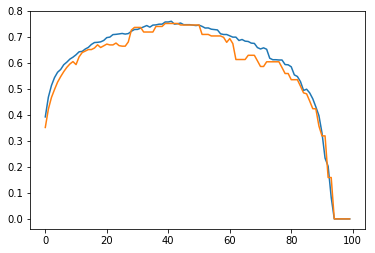

===== n_train = 1 =====
train result: (0.44, 0.7504438597340283)
val result: (0.48, 0.7404660284268314)


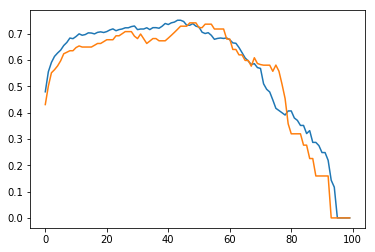

===== n_train = 2 =====
train result: (0.52, 0.7660345057458325)
val result: (0.5, 0.7583350250460863)


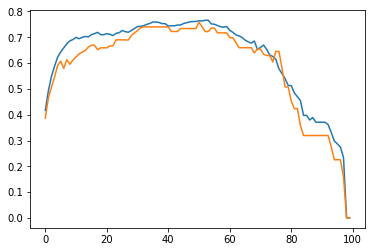

===== n_train = 3 =====
train result: (0.6, 0.7674674814733421)
val result: (0.38, 0.7751663157824217)


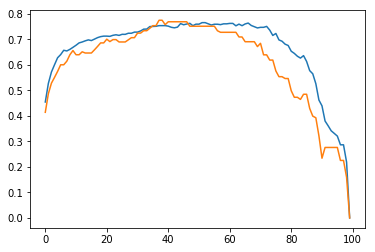

===== n_train = 4 =====
train result: (0.51, 0.7410129824151078)
val result: (0.5, 0.7578880825776165)


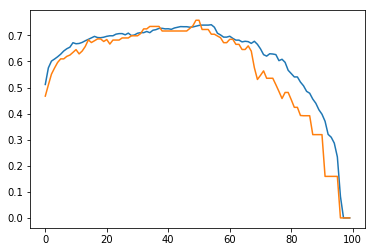

===== n_train = 5 =====
train result: (0.5, 0.7160166559257687)
val result: (0.47000000000000003, 0.7691852436377984)


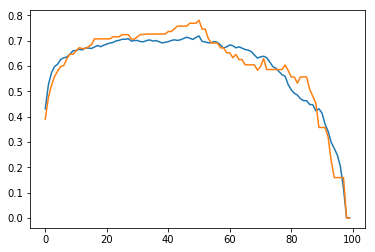

===== n_train = 6 =====
train result: (0.63, 0.7516766840664324)
val result: (0.51, 0.7691852436377984)


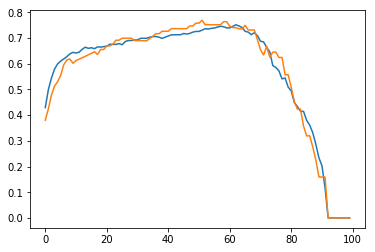

===== n_train = 7 =====
train result: (0.6, 0.7424807809458008)
val result: (0.58, 0.751709811252909)


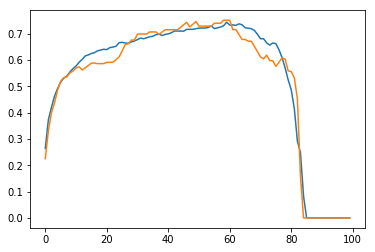

===== n_train = 8 =====
train result: (0.54, 0.751781364761438)
val result: (0.46, 0.7758947879246116)


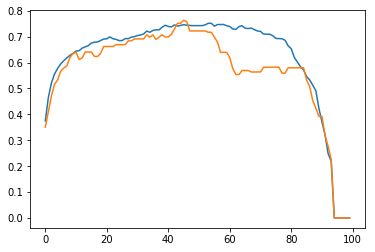

===== n_train = 9 =====
train result: (0.5, 0.757442269011052)
val result: (0.48, 0.7158632509670798)


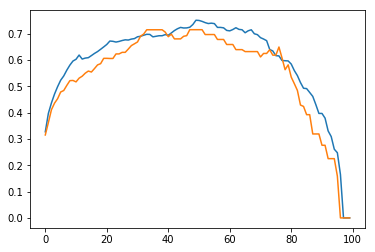

Beginning fold 2
===== n_train = 0 =====
train result: (0.55, 0.7727459438983669)
val result: (0.51, 0.7184421897402913)


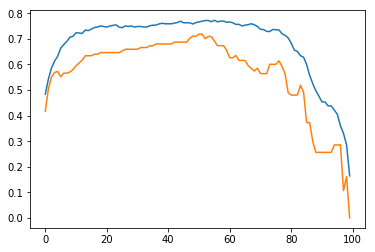

===== n_train = 1 =====
train result: (0.46, 0.7583488769755142)
val result: (0.5, 0.7267539025041305)


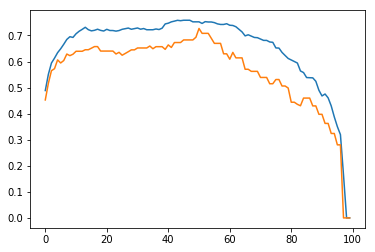

===== n_train = 2 =====
train result: (0.56, 0.8066621909886994)
val result: (0.43, 0.7584427469178359)


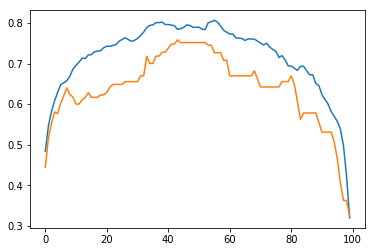

===== n_train = 3 =====
train result: (0.48, 0.7734990784927499)
val result: (0.51, 0.7655037776728455)


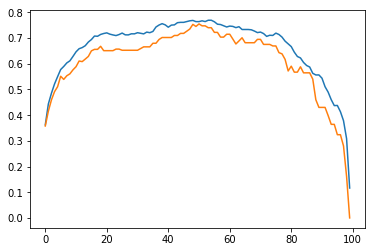

===== n_train = 4 =====
train result: (0.36, 0.7227096203975968)
val result: (0.49, 0.7750987918700384)


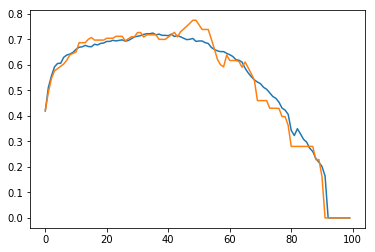

===== n_train = 5 =====
train result: (0.49, 0.7776007016645496)
val result: (0.43, 0.7002012101718899)


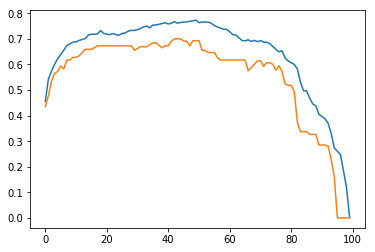

===== n_train = 6 =====
train result: (0.43, 0.8055264687412218)
val result: (0.47000000000000003, 0.7655037776728455)


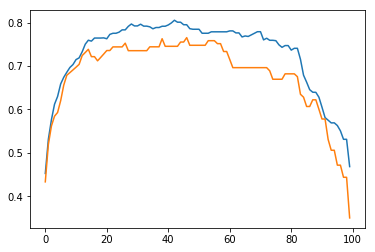

===== n_train = 7 =====
train result: (0.53, 0.747176344346231)
val result: (0.49, 0.7090160036673936)


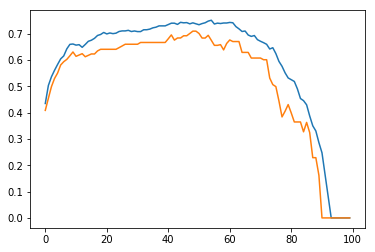

===== n_train = 8 =====
train result: (0.3, 0.700688782769474)
val result: (0.51, 0.7002012101718899)


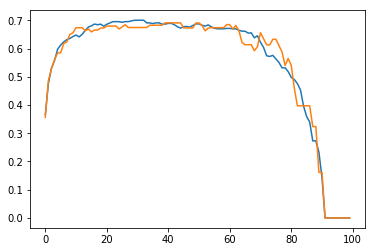

===== n_train = 9 =====
train result: (0.58, 0.7676836685506316)
val result: (0.5, 0.7629779906079485)


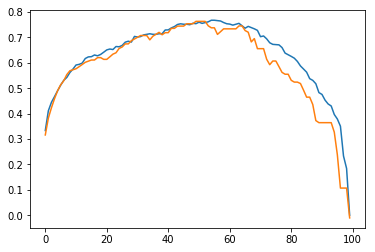

Beginning fold 3
===== n_train = 0 =====
train result: (0.51, 0.775446284364847)
val result: (0.46, 0.7313358487597429)


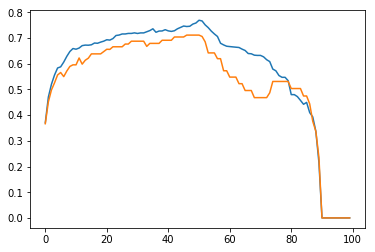

===== n_train = 1 =====
train result: (0.5, 0.7675053312810507)
val result: (0.56, 0.7420949662544768)


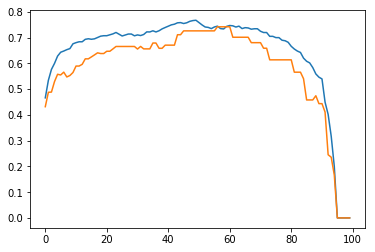

===== n_train = 2 =====
train result: (0.48, 0.744571917796862)
val result: (0.49, 0.7461244938802352)


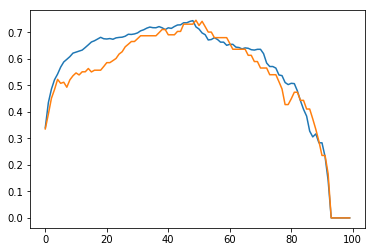

===== n_train = 3 =====
train result: (0.51, 0.7447216076503074)
val result: (0.52, 0.7809620567888277)


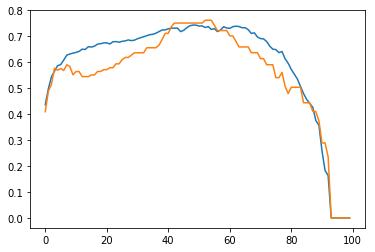

===== n_train = 4 =====
train result: (0.52, 0.807744922022132)
val result: (0.5, 0.7172937038231363)


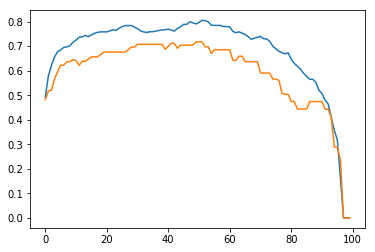

===== n_train = 5 =====
train result: (0.62, 0.7181264615922142)
val result: (0.5, 0.7172937038231363)


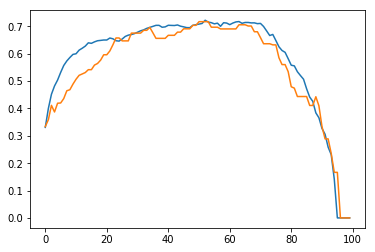

===== n_train = 6 =====
train result: (0.63, 0.8020351388553068)
val result: (0.36, 0.7509694645660066)


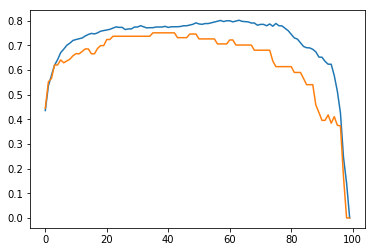

===== n_train = 7 =====
train result: (0.47000000000000003, 0.7690914925470852)
val result: (0.47000000000000003, 0.7313358487597429)


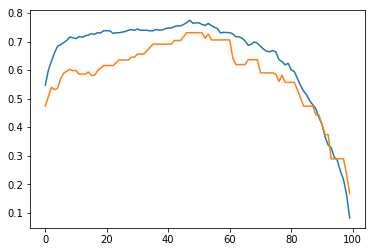

===== n_train = 8 =====
train result: (0.54, 0.7505343013440853)
val result: (0.47000000000000003, 0.7112869309716426)


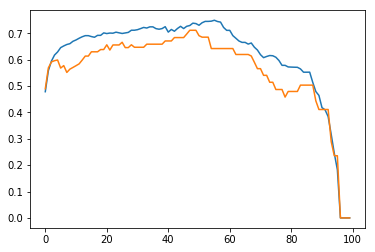

===== n_train = 9 =====
train result: (0.48, 0.7340048824781774)
val result: (0.48, 0.7461244938802352)


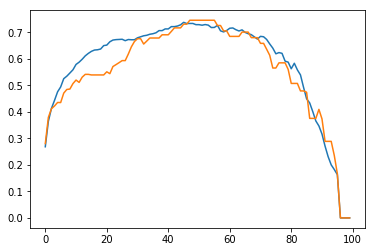

Beginning fold 4
===== n_train = 0 =====
train result: (0.13, 0.7845510231715447)
val result: (0.53, 0.7997983857964946)


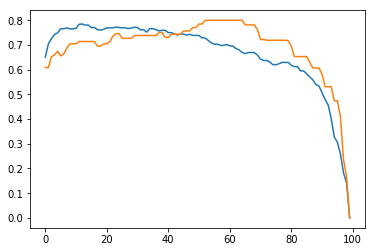

===== n_train = 1 =====
train result: (0.48, 0.7649744776082777)
val result: (0.58, 0.6949289069860497)


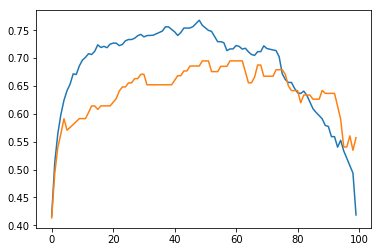

===== n_train = 2 =====
train result: (0.23, 0.7553740664215745)
val result: (0.49, 0.7644352101814816)


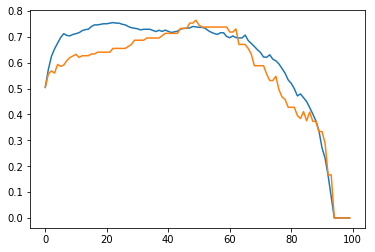

===== n_train = 3 =====
train result: (0.39, 0.7027630493960233)
val result: (0.43, 0.6875337290879655)


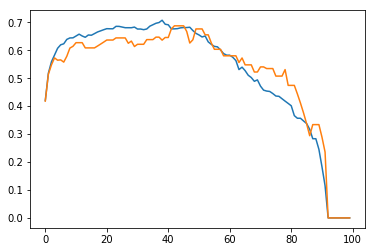

===== n_train = 4 =====
train result: (0.3, 0.7674583195392474)
val result: (0.47000000000000003, 0.7812736103615758)


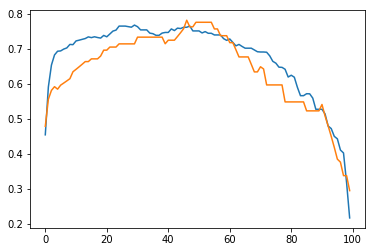

===== n_train = 5 =====
train result: (0.42, 0.7781947151104557)
val result: (0.36, 0.7266634313294674)


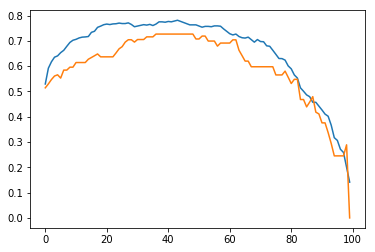

===== n_train = 6 =====
train result: (0.46, 0.7855398676244567)
val result: (0.56, 0.7875077012846029)


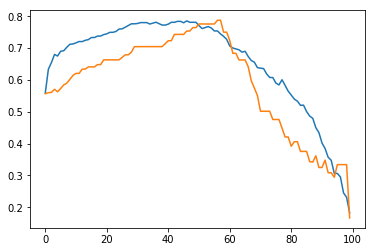

===== n_train = 7 =====
train result: (0.52, 0.7874303735525506)
val result: (0.52, 0.7689289805661292)


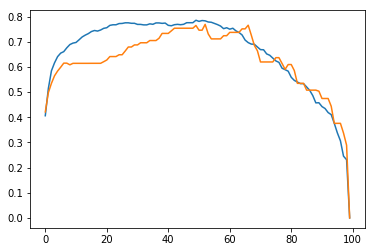

===== n_train = 8 =====
train result: (0.52, 0.7765500352069638)
val result: (0.6, 0.6990945409873431)


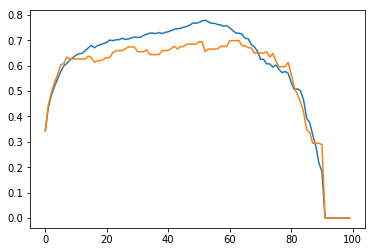

===== n_train = 9 =====
train result: (0.26, 0.7723325575882511)
val result: (0.5, 0.7624694805883564)


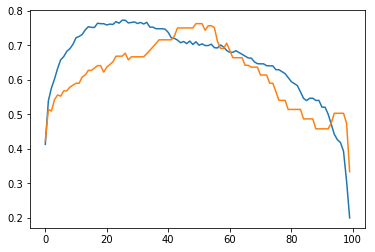

Beginning fold 5
===== n_train = 0 =====
train result: (0.29, 0.7868896365891513)
val result: (0.52, 0.7874840959105226)


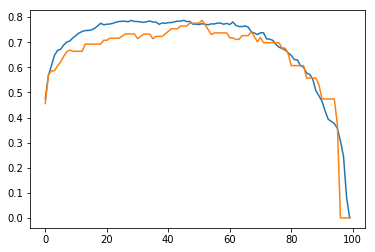

===== n_train = 1 =====
train result: (0.62, 0.7506292324888786)
val result: (0.4, 0.760026890999628)


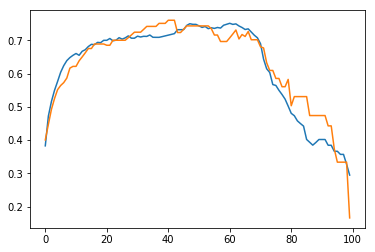

===== n_train = 2 =====
train result: (0.63, 0.7363495679142886)
val result: (0.46, 0.7509206501021445)


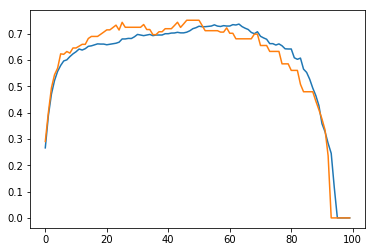

===== n_train = 3 =====
train result: (0.42, 0.7711709278121692)
val result: (0.49, 0.799732344728172)


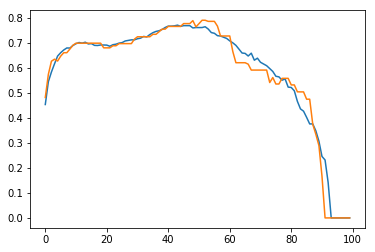

===== n_train = 4 =====
train result: (0.52, 0.7265772385802053)
val result: (0.5, 0.751466302364382)


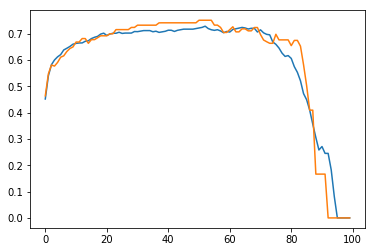

===== n_train = 5 =====
train result: (0.41000000000000003, 0.7438838622712755)
val result: (0.47000000000000003, 0.7564177657166685)


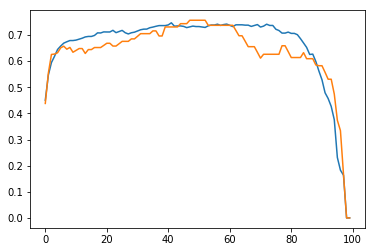

===== n_train = 6 =====
train result: (0.32, 0.775018654462307)
val result: (0.5, 0.7420494809566712)


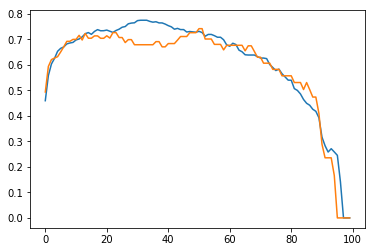

===== n_train = 7 =====
train result: (0.45, 0.7584043364655858)
val result: (0.55, 0.7846031067030322)


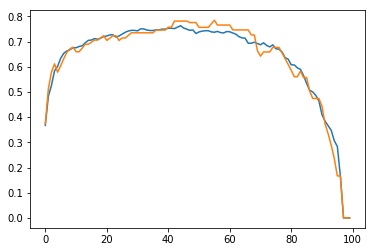

===== n_train = 8 =====
train result: (0.45, 0.7646704478204395)
val result: (0.48, 0.7644083826323443)


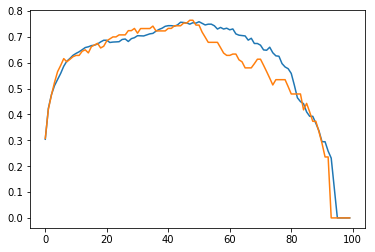

===== n_train = 9 =====
train result: (0.43, 0.7765432835857539)
val result: (0.44, 0.7809213616099598)


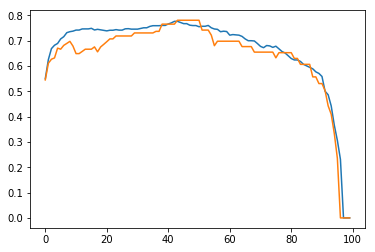

In [39]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))

    for n_train in range(N_TRAIN):
        print(f"===== n_train = {n_train} =====")
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))
        plot_score(train_y, preds_train)
        plot_score(val_y, preds_val)
        plt.show()

#### (n_train)単位で結果を出力

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.4, 0.751709811252909)
fold1 result: (0.51, 0.7184421897402913)
fold2 result: (0.46, 0.7313358487597429)
fold3 result: (0.53, 0.7997983857964946)
fold4 result: (0.52, 0.7874840959105226)
val result: (0.48, 0.7376238291794645)
===== n_train = 1 =====
fold0 result: (0.48, 0.7404660284268314)
fold1 result: (0.5, 0.7267539025041305)
fold2 result: (0.56, 0.7420949662544768)
fold3 result: (0.58, 0.6949289069860497)
fold4 result: (0.4, 0.760026890999628)
val result: (0.5, 0.7225887978771717)
===== n_train = 2 =====
fold0 result: (0.5, 0.7583350250460863)
fold1 result: (0.43, 0.7584427469178359)
fold2 result: (0.49, 0.7461244938802352)
fold3 result: (0.49, 0.7644352101814816)
fold4 result: (0.46, 0.7509206501021445)
val result: (0.5, 0.7492404112759278)
===== n_train = 3 =====
fold0 result: (0.38, 0.7751663157824217)
fold1 result: (0.51, 0.7655037776728455)
fold2 result: (0.52, 0.7809620567888277)
fold3 result: (0.43, 0.6875337290879655)
fold4 result: (0.49, 0.799732344728172)


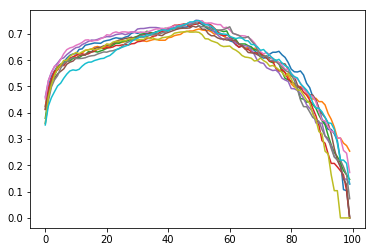

In [40]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)

    print("val result:", threshold_search(y_val, preds_val_all))
    plot_score(y_val, preds_val_all)

### adversarial validation

In [41]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0").sort_values("idx")
ad_val_idx = ad_train.query("preds > 0.75").idx.values
len(ad_val_idx)

303

In [42]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    val_idx_list = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        val_idx_list.append(val_idx)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)
    val_idx_list = np.concatenate(val_idx_list)
    
    result_df = []
    for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
        result_df.append((idx, target, preds))
    result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
    result_df = result_df.sort_values("idx").reset_index(drop=True)
    extract = result_df.query("idx in @ad_val_idx")

    print("val result:", threshold_search(y_val, preds_val_all))
    print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.4, 0.751709811252909)
fold1 result: (0.51, 0.7184421897402913)
fold2 result: (0.46, 0.7313358487597429)
fold3 result: (0.53, 0.7997983857964946)
fold4 result: (0.52, 0.7874840959105226)
val result: (0.48, 0.7376238291794645)
adverl result: (0.52, 0.6107531358900427)
===== n_train = 1 =====
fold0 result: (0.48, 0.7404660284268314)
fold1 result: (0.5, 0.7267539025041305)
fold2 result: (0.56, 0.7420949662544768)
fold3 result: (0.58, 0.6949289069860497)
fold4 result: (0.4, 0.760026890999628)
val result: (0.5, 0.7225887978771717)
adverl result: (0.35000000000000003, 0.49659772562673127)
===== n_train = 2 =====
fold0 result: (0.5, 0.7583350250460863)
fold1 result: (0.43, 0.7584427469178359)
fold2 result: (0.49, 0.7461244938802352)
fold3 result: (0.49, 0.7644352101814816)
fold4 result: (0.46, 0.7509206501021445)
val result: (0.5, 0.7492404112759278)
adverl result: (0.4, 0.5574295856750048)
===== n_train = 3 =====
fold0 result: (0.38, 0.7751663157824217)
fold1 result: (0.51, 0

### predict v1

- n_train = 2の予測を出力
- LB = 0.640, adverl_resultと似ている？

In [23]:
n_train = 8

In [24]:
preds_test = []
for idx in range(N_SPLITS):
    pred = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
    pred_3 = []

    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)

In [25]:
best_threshold = 0.49
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

(20337,)

In [26]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = preds_test
submission.to_csv(save_dir + f'submission_v1_ntrain{n_train}.csv', index=False)
submission.sum()

signal_id    383962560
target             744
dtype: int64

### predict v2

- 全ての(idx, fold)を足し合わせる

In [17]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
y_val = []
val_idx_list = []
preds_test_all = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]

    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_val_idx += preds_val / N_TRAIN
        preds_test_idx += preds_test / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
    preds_test_all.append(preds_test_idx)
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.41000000000000003, 0.7643574249945958)
(0.52, 0.7760421337099255)
(0.55, 0.7617303562939804)
(0.6, 0.7564427077306826)
(0.51, 0.7890550804810933)
val result: (0.54, 0.7592486107622786)


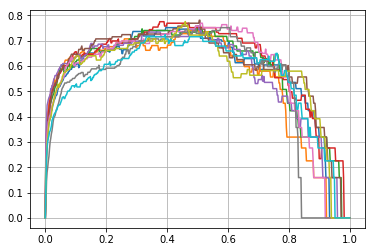

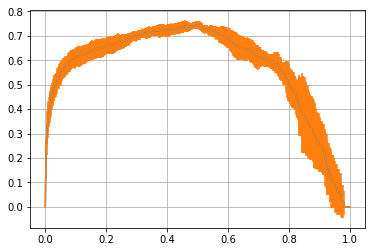

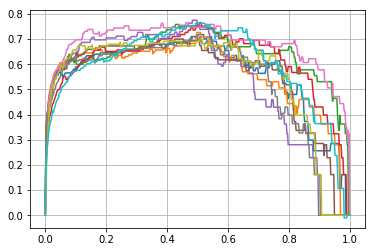

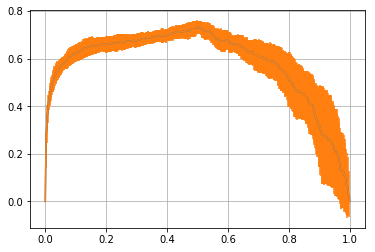

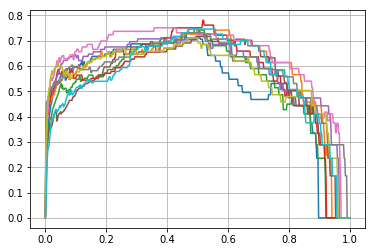

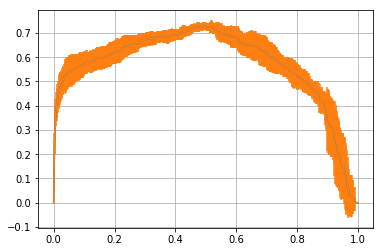

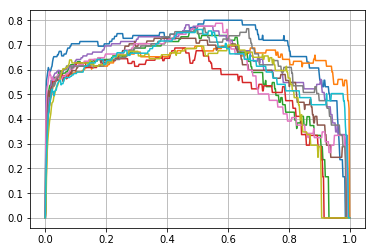

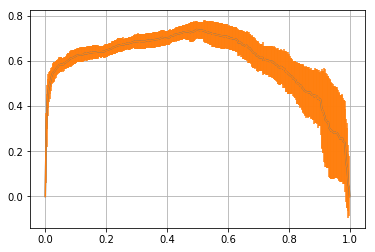

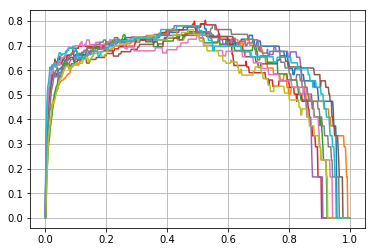

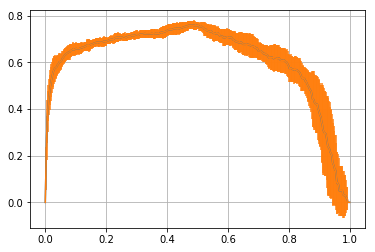

In [18]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

In [19]:
thr = 0.54
preds_test_sub = np.zeros(len(X_test_input))
for idx, (train_idx, val_idx) in enumerate(splits):
    preds_test_idx = preds_test_all[idx]
    preds_test_sub += preds_test_idx / len(splits)
    
preds_test_sub = (preds_test_sub > thr).astype(int)
preds_test_sub.sum()

215

In [20]:
pred_3 = []
for pred_scaler in preds_test_sub:
    for i in range(3):
        pred_3.append(pred_scaler)
sub = np.squeeze(pred_3)
sub.sum()

645

In [21]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = sub
submission['target'] = submission['target'].astype(int)
submission.to_csv(save_dir + 'submission_v2.csv', index=False)
submission.sum()

signal_id    383962560
target             645
dtype: int64

### predict v3

- 全ての(idx, fold)をsigmoidにスケール変換
- 足し合わせて閾値を決める

In [45]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        calb = _SigmoidCalibration()
        calb.fit(preds_val, val_y)
        preds_val = calb.predict(preds_val)
        preds_test = calb.predict(preds_test)
        preds_val_idx += preds_val / N_TRAIN
        preds_test_idx += preds_test / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.26, 0.7751663157824217)
(0.35000000000000003, 0.7760421337099255)
(0.48, 0.7617303562939804)
(0.26, 0.7644352101814816)
(0.41000000000000003, 0.7890550804810933)
val result: (0.41000000000000003, 0.753225873482462)


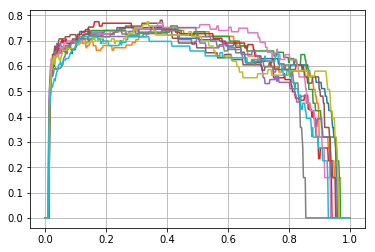

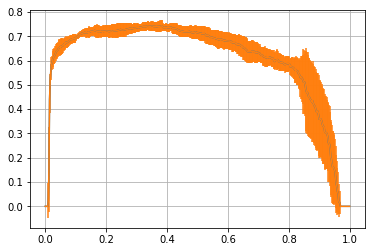

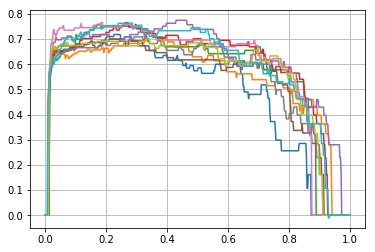

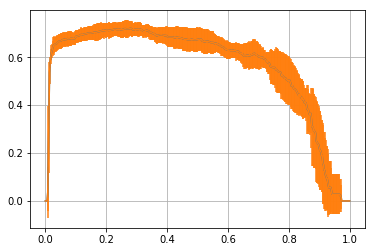

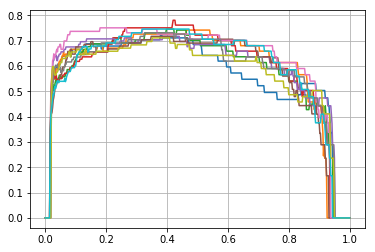

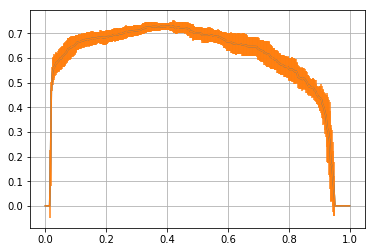

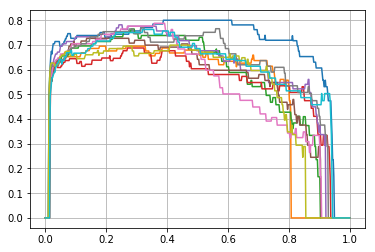

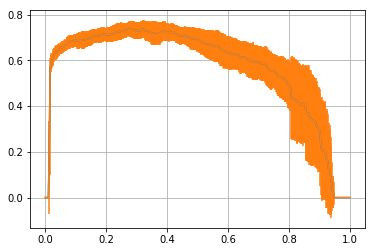

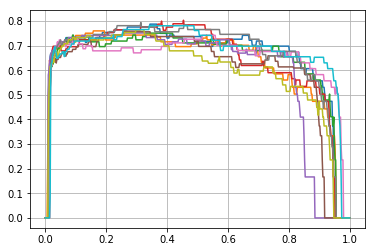

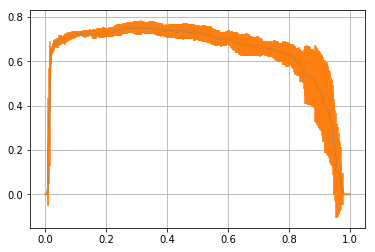

In [46]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

In [47]:
thr = 0.41
preds_test_sub = np.zeros(len(X_test_input))
for idx, (train_idx, val_idx) in enumerate(splits):
    preds_test_idx = preds_test_all[idx]
    preds_test_sub += preds_test_idx / len(splits)
    
preds_test_sub = (preds_test_sub > thr).astype(int)
preds_test_sub.sum()

231

In [48]:
pred_3 = []
for pred_scaler in preds_test_sub:
    for i in range(3):
        pred_3.append(pred_scaler)
sub = np.squeeze(pred_3)
sub.sum()

693

In [49]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = sub
submission['target'] = submission['target'].astype(int)
submission.to_csv(save_dir + 'submission_v3.csv', index=False)
submission.sum()

signal_id    383962560
target             693
dtype: int64

### predict v4

- 全ての(idx, fold)をrankdataでスケール変換
- 足し合わせて閾値を決める

In [25]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_con = np.concatenate((preds_val, preds_test))
        preds_con = rankdata(preds_con) / len(preds_con)
        preds_val_rank = preds_con[0:len(preds_val)]
        preds_test_rank = preds_con[len(preds_val):len(preds_val)+len(preds_test)]
        preds_val_idx += preds_val_rank / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
val_idx_list = np.concatenate(val_idx_list)
result_df = []
for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
    result_df.append((idx, target, preds))
result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
result_df = result_df.sort_values("idx").reset_index(drop=True)
extract = result_df.query("idx in @ad_val_idx")

print("val result:", threshold_search(y_val, preds_val_all))
print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

(0.9500000000000001, 0.7419595527914675)
(0.96, 0.7339117527952347)
(0.96, 0.7516547735251194)
(0.97, 0.6997985794736116)
(0.93, 0.6709862765338721)
val result: (0.9500000000000001, 0.7099440449269994)
adverl result: (0.9400000000000001, 0.6002884557845183)
